In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import argparse
from prophet import Prophet

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('strings', metavar='STRING', nargs='*', help='String for searching')
parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')
parser.add_argument('--predict_periods', help="How many periods to the future to predict.", type=int, default=365)
parser.add_argument('--data_file', help="File name with dataset.", type=str, default='accidents_daily.csv')

args = parser.parse_args()

periods_to_predict = int(args.predict_periods)
data_file = args.data_file

In [3]:
dataset_df = pd.read_csv(data_file, index_col='date', parse_dates=True)

dataset_df

y
date           
2016-01-01  450
2016-01-02  148
2016-01-03   99
2016-01-04  344
2016-01-05  271
...         ...
2022-12-27  169
2022-12-28  157
2022-12-29  151
2022-12-30  157
2022-12-31  111

[2557 rows x 1 columns]

In [4]:
# split the data to training set and test set

column_names = ['ds', 'y']  # ds = date, y = number of accidents in that day/month

# train set = years 2016-2021, test set = year 2022
dataset_train = dataset_df[:len(dataset_df) - periods_to_predict].reset_index()  # reserve last 12 observation as test set
dataset_train.columns = column_names
dataset_test = dataset_df[len(dataset_df) - periods_to_predict:].reset_index()
dataset_test.columns = column_names

print(dataset_train)
print(dataset_test)

             ds    y
0    2016-01-01  450
1    2016-01-02  148
2    2016-01-03   99
3    2016-01-04  344
4    2016-01-05  271
...         ...  ...
2187 2021-12-27  214
2188 2021-12-28  199
2189 2021-12-29  181
2190 2021-12-30  198
2191 2021-12-31  141

[2192 rows x 2 columns]
            ds    y
0   2022-01-01  543
1   2022-01-02  123
2   2022-01-03  234
3   2022-01-04  246
4   2022-01-05  219
..         ...  ...
360 2022-12-27  169
361 2022-12-28  157
362 2022-12-29  151
363 2022-12-30  157
364 2022-12-31  111

[365 rows x 2 columns]


In [5]:
# daily_count = pd.concat([daily_count_train, daily_count_test[len(daily_count_test) - days_to_predict:]])
# monthly_count = pd.concat([monthly_count_train, monthly_count_test[len(monthly_count_test) - months_to_predict:]])
# print(daily_count)
# print(monthly_count)

dataset_df.reset_index(inplace=True)
dataset_df.columns = column_names

print(dataset_df)

             ds    y
0    2016-01-01  450
1    2016-01-02  148
2    2016-01-03   99
3    2016-01-04  344
4    2016-01-05  271
...         ...  ...
2552 2022-12-27  169
2553 2022-12-28  157
2554 2022-12-29  151
2555 2022-12-30  157
2556 2022-12-31  111

[2557 rows x 2 columns]


In [6]:
# create a monthly dataframe that will contain forecasts from all applied algorithms
predict_df = pd.DataFrame(dataset_df['ds'])

# add new dates to the monthly_predict_df in the length of months from the arguments
last_date = dataset_df['ds'].max()
next_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(next_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

predict_df = pd.concat([predict_df, new_rows])

predict_df['original'] = list(dataset_train['y']) + list(dataset_test['y']) + [None] * periods_to_predict
predict_df.set_index('ds', inplace=True)

predict_df

original
ds                  
2016-01-01     450.0
2016-01-02     148.0
2016-01-03      99.0
2016-01-04     344.0
2016-01-05     271.0
...              ...
2023-12-27       NaN
2023-12-28       NaN
2023-12-29       NaN
2023-12-30       NaN
2023-12-31       NaN

[2922 rows x 1 columns]

In [13]:
# Prophet

prophet_model = Prophet()  # create new object for monthly forecast
prophet_model.fit(dataset_train)  # fit the training data
future = prophet_model.make_future_dataframe(periods=periods_to_predict + periods_to_predict, freq='1d')  # set length of forecast
forecast = prophet_model.predict(future)  # predict for the number of observations set in the previous step

13:46:42 - cmdstanpy - INFO - Chain [1] start processing
13:46:42 - cmdstanpy - INFO - Chain [1] done processing


Text(83.09722222222221, 0.5, 'number of accidents')

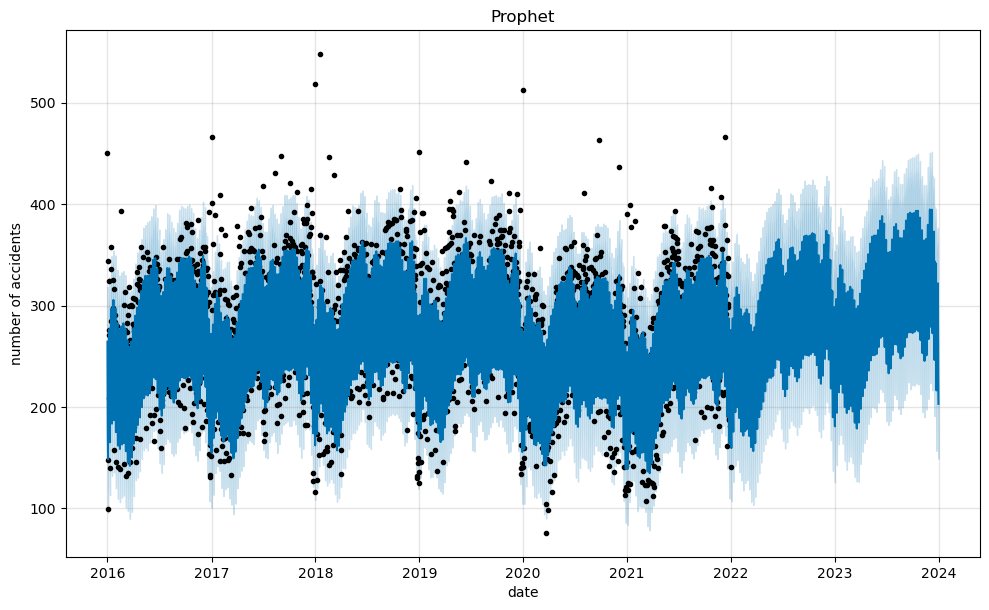

In [14]:
fig1 = prophet_model.plot(forecast)  # plot the monthly forecast
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

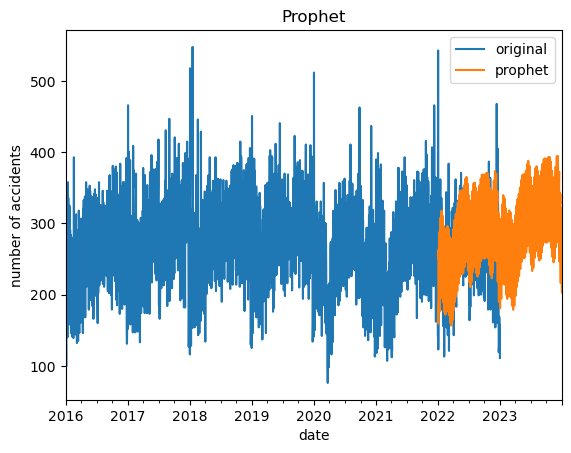

In [15]:
predict_df['prophet'] = [None]*len(dataset_train) + list(forecast['yhat'].tail(periods_to_predict + periods_to_predict))  # add the forecast to monthly_predict_df

predict_df[['original', 'prophet']].plot()
plt.title("Prophet")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [16]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(dataset_train['ds'].values.reshape(-1, 1), dataset_train['y'].values)  # fit the training data

print("Best parameters: ", grid_search.best_params_)  # print the most optimal hyperparameter values
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 10, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score:  -0.0679711556113769


In [17]:
# SVR - monthly
svr_model = SVR(kernel='sigmoid', gamma='scale', C=0.1, epsilon=0.01)  # create model with values from the GridSearchCV
svr_model.fit(dataset_train.index.values.reshape(-1, 1), dataset_train['y'].values)  # fit the training data

y_pred = svr_model.predict(dataset_test.index.values.reshape(-1, 1))

y_pred

array([281.53003585, 281.52549129, 281.52094731, 281.51640445,
       281.51186329, 281.50732438, 281.5027883 , 281.4982556 ,
       281.49372686, 281.48920262, 281.48468347, 281.48016995,
       281.47566263, 281.47116207, 281.46666883, 281.46218348,
       281.45770656, 281.45323864, 281.44878028, 281.44433202,
       281.43989444, 281.43546807, 281.43105347, 281.4266512 ,
       281.42226181, 281.41788584, 281.41352384, 281.40917636,
       281.40484394, 281.40052713, 281.39622647, 281.3919425 ,
       281.38767575, 281.38342677, 281.37919608, 281.37498423,
       281.37079174, 281.36661914, 281.36246695, 281.35833571,
       281.35422594, 281.35013815, 281.34607286, 281.3420306 ,
       281.33801186, 281.33401717, 281.33004703, 281.32610195,
       281.32218243, 281.31828896, 281.31442206, 281.3105822 ,
       281.30676989, 281.30298561, 281.29922985, 281.29550308,
       281.2918058 , 281.28813847, 281.28450157, 281.28089557,
       281.27732093, 281.27377812, 281.27026759, 281.26

Text(0, 0.5, 'number of accidents')

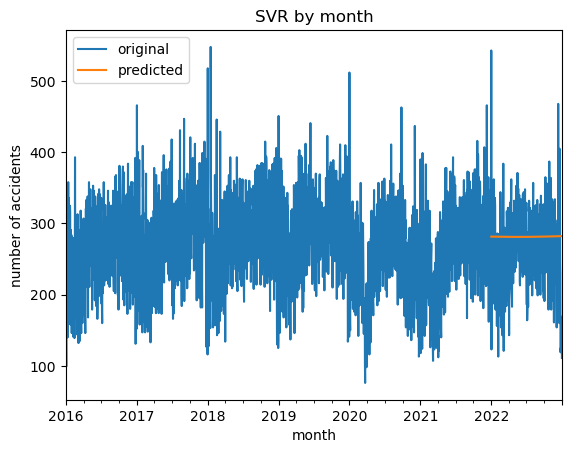

In [18]:
# plot the whole dataset + add predicted values for 2022
svr_predict_df = pd.DataFrame(dataset_df)
svr_predict_df['forecast_value'] = [None]*len(dataset_train) + list(y_pred)

svr_predict_df.set_index('ds', inplace=True)
svr_predict_df.columns = ["original", "predicted"]
svr_predict_df.plot()
plt.title("SVR by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [201]:
from scalecast.Forecaster import Forecaster

In [202]:
# create a Forecaster object that will make forecasts from multiple models
f_model = Forecaster(
    y=np.array(dataset_df.reset_index()['y']),
    current_dates=np.array(dataset_df.reset_index()['ds'])
)
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [203]:
f_model.set_test_length(periods_to_predict)  # reserve last n observations as a test set
f_model.generate_future_dates(periods_to_predict)  # predict 12 months into the future
f_model.set_validation_length(f_model.test_length)
f_model.auto_Xvar_select()
f_model

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=365
    Xvars=['lnt', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53']
    TestLength=365
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [206]:
forecaster_estimators = ['arima', 'svr', 'xgboost', 'catboost', 'rnn', 'lstm']  # models that will by predicted by Forecaster
for estimator in forecaster_estimators:
    f_model.set_estimator(estimator)
    f_model.tune()  # find optimal hyperparameters for selected method
    f_model.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {estimator}:')
    print(f_model.best_params)  # print the most optimal hyperparameters

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 1, 1, 7)}
Hyperparameter values for svr:
{'kernel': 'linear', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}
Hyperparameter values for xgboost:
{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 3, 'subsample': 0.9}
Hyperparameter values for catboost:
{'iterations': 200, 'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 3, 'verbose': 0}
67/67 [==============================] - 2s 35ms/step
Hyperparameter values for rnn:
{'layers_struct': [('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'relu', 'return_sequences': False})], 'epochs': 25, 'verbose': 0}
67/67 [==============================] - 7s 105ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'relu', 'dropout': (0.2, 0.2, 0.2), 'lags': 50, 'verbose': 0, 'epochs': 25}


Text(0, 0.5, 'number of accidents')

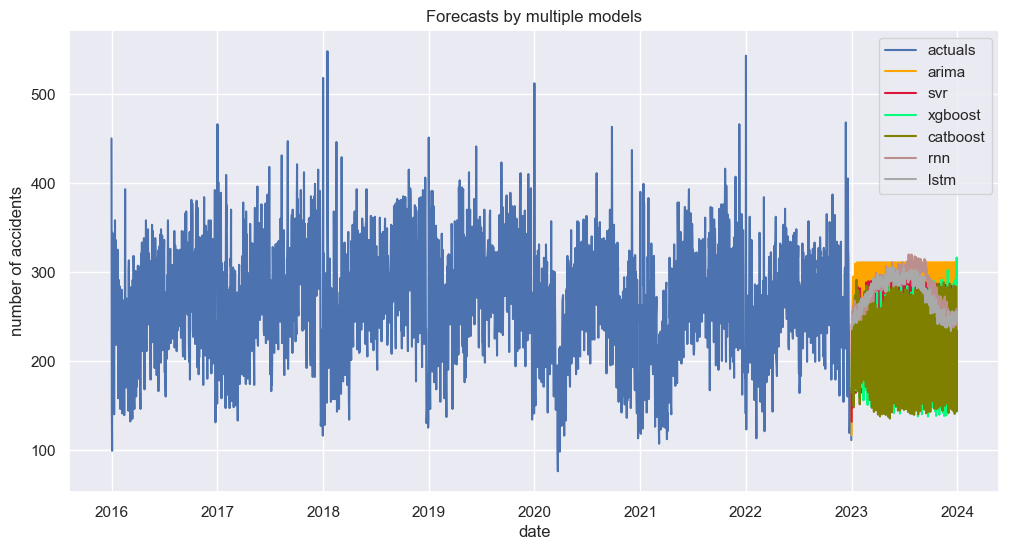

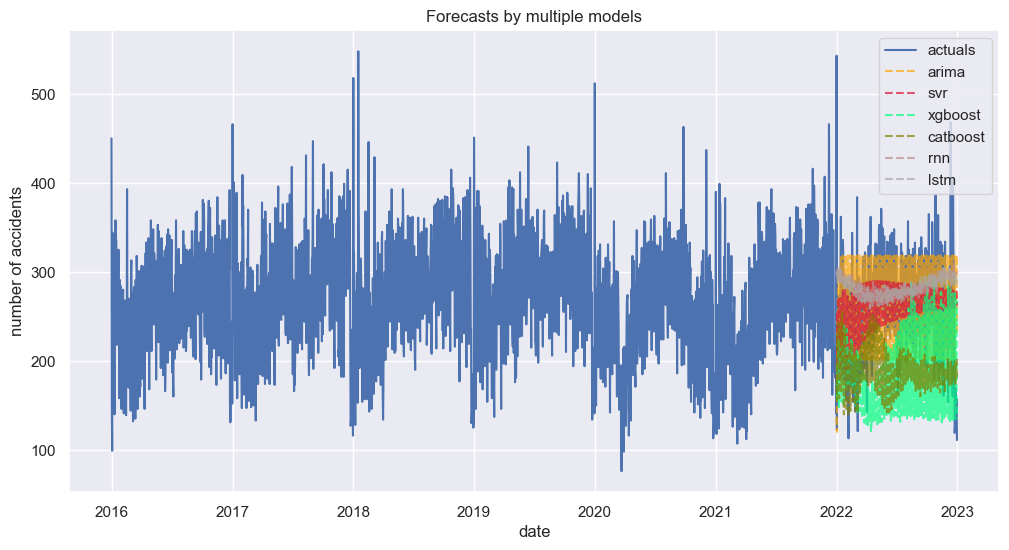

In [207]:
f_model.plot()  # plots future values
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")
f_model.plot_test_set()  # plots values from test set
plt.title("Forecasts by multiple models")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [214]:
# add forecasts from models in Forecaster to monthly_predict_df
for method in forecaster_estimators:
    result = f_model.export_fitted_vals(method)
    predict_df[method] = [None] * len(dataset_train) + list(result.tail(periods_to_predict + periods_to_predict)['FittedVals'])

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_genetic import GASearchCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn.metrics import accuracy_score

In [38]:
# split datetime to day, month, and year parts for models with GA
dataset_ga = dataset_df
dataset_ga['day'] = dataset_df['ds'].dt.day
dataset_ga['month'] = dataset_df['ds'].dt.month
dataset_ga['year'] = dataset_df['ds'].dt.year
dataset_ga

ds    y  forecast_value  day  month  year
0    2016-01-01  450             NaN    1      1  2016
1    2016-01-02  148             NaN    2      1  2016
2    2016-01-03   99             NaN    3      1  2016
3    2016-01-04  344             NaN    4      1  2016
4    2016-01-05  271             NaN    5      1  2016
...         ...  ...             ...  ...    ...   ...
2552 2022-12-27  169      282.148419   27     12  2022
2553 2022-12-28  157      282.155514   28     12  2022
2554 2022-12-29  151      282.162612   29     12  2022
2555 2022-12-30  157      282.169712   30     12  2022
2556 2022-12-31  111      282.176814   31     12  2022

[2557 rows x 6 columns]

In [39]:
# split data to training and testing sets
X = dataset_ga[['day', 'month', 'year']]
y = dataset_ga['y']
X_train_ga = X[:len(X) - periods_to_predict]
X_test_ga = X[len(X) - periods_to_predict:]
y_train_ga = y[:len(y) - periods_to_predict]  # test set = observations from the last year
y_test_ga = y[len(y) - periods_to_predict:]
X_train_ga.shape, X_test_ga.shape, y_train_ga.shape, y_test_ga.shape

((2192, 3), (365, 3), (2192,), (365,))

In [40]:
rf = RandomForestRegressor(random_state=111)

In [41]:
# adapters used in GA Search
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [42]:
# grid with attributes for random forest, for genetic algorithm
rf_grid_ga = {
    'n_estimators': Integer(100, 600),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'max_depth': Integer(2,20),
    'criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'min_samples_split': Continuous(0.1, 0.9),
    'bootstrap': Categorical([True, False])
}

In [43]:
rf_estimator_ga = GASearchCV(estimator=rf,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [44]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)  # fit the training data

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	100   	-0.112634	0.084088   	0.00420623 	-0.286996  
1  	200   	-0.036275	0.0453989  	0.00420623 	-0.220627  
2  	200   	-0.00899024	0.0163082  	0.00420623 	-0.061973  
3  	200   	0.00072616 	0.00436229 	0.0054778  	-0.0166847 
4  	200   	0.00308652 	0.00267354 	0.00554552 	-0.00999877
5  	200   	0.00448621 	0.00136566 	0.00694564 	0.000326957
6  	200   	0.00532826 	0.00056102 	0.00696457 	0.00412726 
7  	200   	0.00567015 	0.00104545 	0.0082299  	-0.00332901
8  	200   	0.00614141 	0.000713435	0.00852784 	0.00491869 
9  	200   	0.00658179 	0.000705152	0.00852784 	0.00532475 
10 	200   	0.00704327 	0.000701983	0.00852784 	0.00604966 
11 	200   	0.0076208  	0.000622993	0.00852784 	0.00631933 
12 	200   	0.008019   	0.000532562	0.00858404 	0.00421217 


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000002982F2002E0>,
           error_score='raise',
           estimator=RandomForestRegressor(criterion='poisson', max_depth=2,
                                           max_features='auto',
                                           min_samples_split=0.23812006760721058,
                                           n_estimators=511, random_state=111),
           generations=12,
           mutation_probability=<sklearn_genetic.sch...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x00000298252964C0>,
                       'max_features': <sklearn_genetic.space.space.Categorical object at 0x0000029825296FA0>,
                       'min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x0000029825296C70>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x0000029825296C40>},
           population_size=100, return_train_score=True, scoring='r2')

In [45]:
rf_estimator_ga.best_params_

{'n_estimators': 511,
 'max_features': 'auto',
 'max_depth': 2,
 'criterion': 'poisson',
 'min_samples_split': 0.23812006760721058,
 'bootstrap': True}

In [46]:
# prepare testing data with future dates in the length of argument months_to_predict
last_date = dataset_ga.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
X_test_ga = pd.concat([X_test_ga, new_rows])

In [47]:
X_test_ga = X_test_ga[['day', 'month', 'year']]
X_test_ga

day  month  year
2192    1      1  2022
2193    2      1  2022
2194    3      1  2022
2195    4      1  2022
2196    5      1  2022
...   ...    ...   ...
361    27     12  2023
362    28     12  2023
363    29     12  2023
364    30     12  2023
365    31     12  2023

[730 rows x 3 columns]

In [48]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)  # predict future dates

In [49]:
y_predict_rf_ga

array([251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

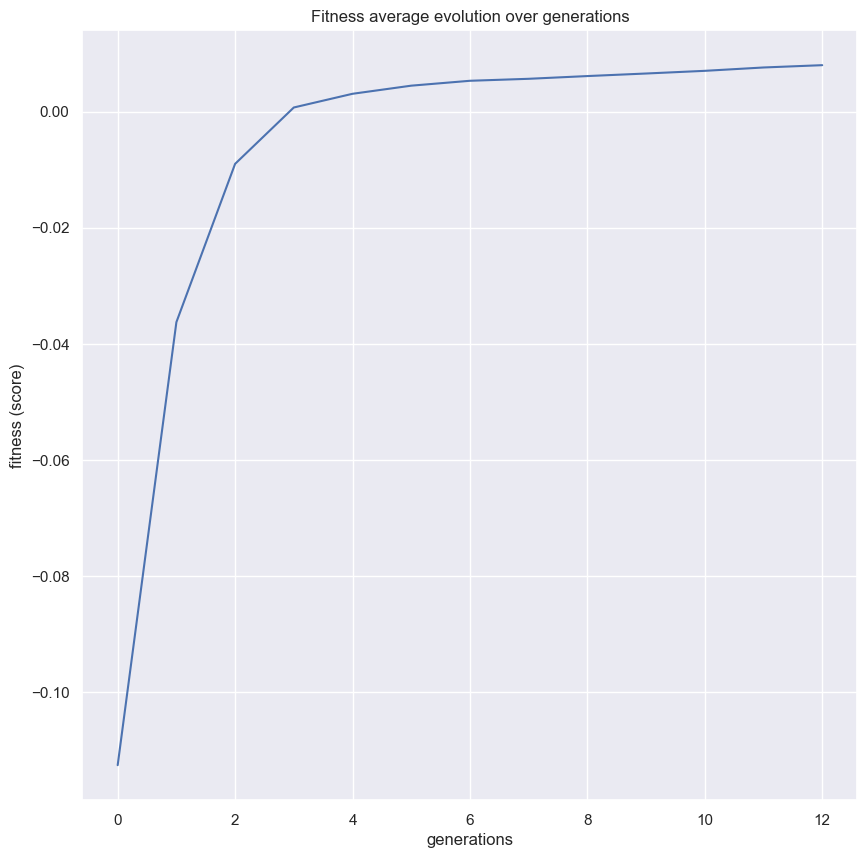

In [50]:
plot_fitness_evolution(rf_estimator_ga)

In [51]:
# prepare dataframe with forecast values (predict_df will contain all hyperparameter optimization techniques)
rf_predict_df = dataset_df[['ds']]

last_date = rf_predict_df.ds.max()
future_dates = pd.date_range(start=last_date, periods=periods_to_predict + 1, freq='1d')
new_rows = pd.DataFrame(future_dates, columns=['ds'])
new_rows = new_rows.iloc[1:]

rf_predict_df = pd.concat([rf_predict_df, new_rows])

rf_predict_df['original'] = list(y_train_ga) + list(y_test_ga) + [None] * periods_to_predict
rf_predict_df['predicted - GA'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)
rf_predict_df.set_index('ds', inplace=True)

Text(0, 0.5, 'number of accidents')

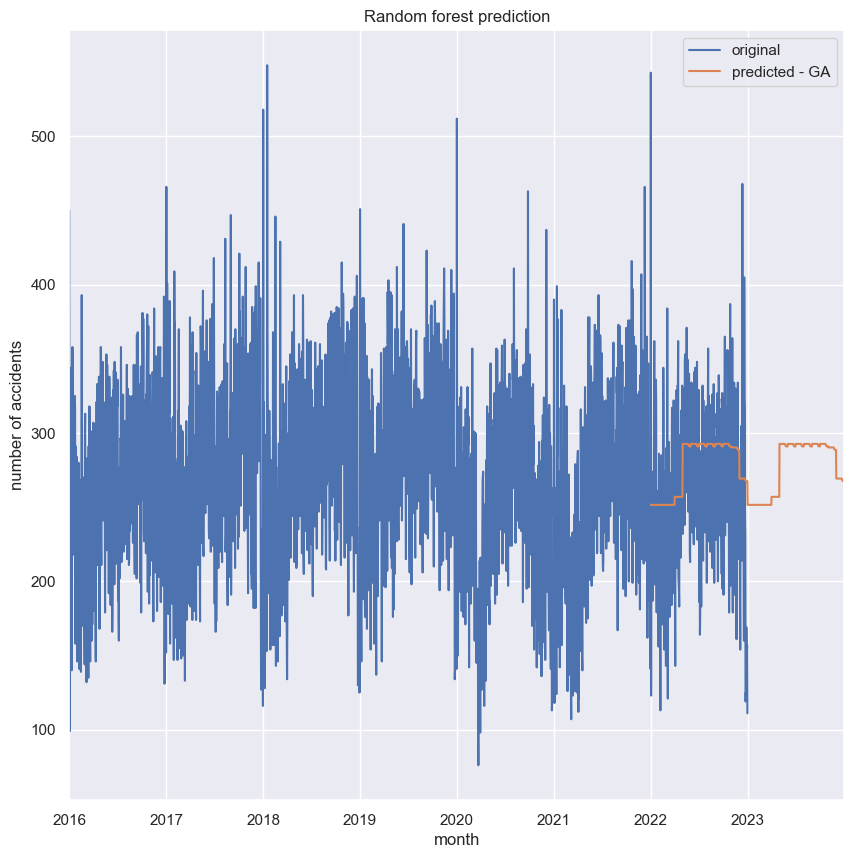

In [52]:
# plot results with random forest and GA
rf_predict_df.plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [53]:
# create grid for randomized searach cv
rf_grid_randomized = {
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.9],
    'bootstrap': [True, False]
}

In [54]:
from sklearn.model_selection import RandomizedSearchCV

In [55]:
rf = RandomForestRegressor(random_state=111)
rf_estimator_randomized = RandomizedSearchCV(estimator=rf,
                                             scoring='r2',
                                             param_distributions = rf_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [56]:
rf_estimator_randomized.fit(X_train_ga, y_train_ga)

RandomizedSearchCV(error_score='raise',
                   estimator=RandomForestRegressor(random_state=111), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['poisson',
                                                      'squared_error',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [0.1, 0.9],
                                        'n_estimators': [100, 600]},
                   random_state=111, scoring='r2')

In [57]:
rf_estimator_randomized.best_params_

{'n_estimators': 100,
 'min_samples_split': 0.1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'absolute_error',
 'bootstrap': False}

In [58]:
y_predict_rf_randomized = rf_estimator_randomized.predict(X_test_ga)

In [59]:
y_predict_rf_randomized

array([277.68 , 239.955, 244.045, 244.48 , 243.675, 248.34 , 248.43 ,
       248.43 , 248.43 , 249.645, 249.645, 249.98 , 249.58 , 249.58 ,
       249.58 , 248.585, 248.585, 248.585, 248.575, 248.575, 248.445,
       248.445, 248.445, 248.445, 248.445, 248.56 , 248.56 , 250.215,
       251.625, 251.625, 251.625, 277.07 , 238.93 , 242.675, 243.125,
       242.32 , 246.72 , 247.01 , 247.01 , 247.01 , 247.63 , 247.63 ,
       247.965, 247.565, 247.565, 247.565, 246.415, 246.415, 246.415,
       246.405, 246.405, 246.275, 246.275, 246.19 , 246.19 , 246.19 ,
       246.305, 246.305, 247.96 , 271.74 , 231.59 , 234.895, 235.285,
       234.48 , 238.88 , 239.17 , 239.17 , 239.17 , 239.62 , 239.62 ,
       239.955, 239.555, 239.555, 239.555, 238.405, 238.405, 238.405,
       238.395, 238.395, 238.265, 238.265, 238.18 , 238.18 , 238.18 ,
       238.295, 238.295, 239.95 , 242.2  , 242.2  , 242.2  , 272.15 ,
       236.055, 240.815, 240.815, 240.01 , 244.675, 244.765, 244.765,
       244.765, 248.

In [60]:
rf_predict_df['predicted - randomized'] = [None] * len(X_train_ga) + list(y_predict_rf_randomized)

Text(0, 0.5, 'number of accidents')

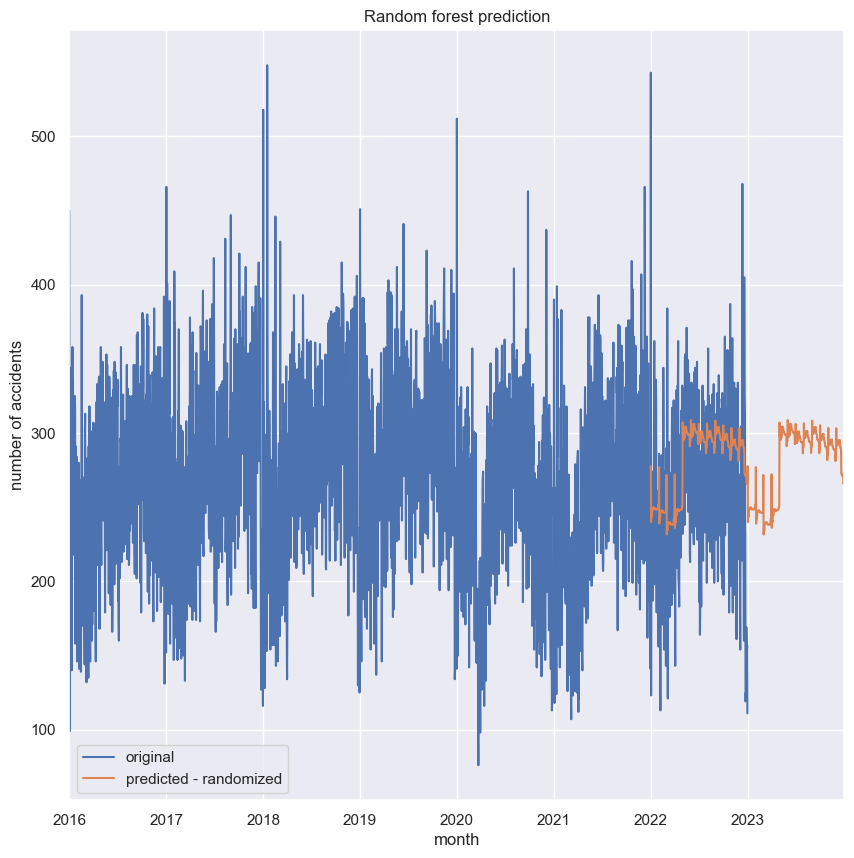

In [61]:
# plot results with random forest and randomized search cv
rf_predict_df[['original', 'predicted - randomized']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [62]:
# grid for grid search cv
rf_grid_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 10, 20],
    'criterion': ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [0.1, 0.5, 0.9],
    'bootstrap': [True, False]
}

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
from sklearn.model_selection import GridSearchCV
rf_estimator_grid = GridSearchCV(estimator=rf,
                                 scoring='r2',
                                 param_grid = rf_grid_grid,
                                 n_jobs=-1,
                                 error_score='raise'
                                )

In [65]:
y_predict_rf_grid = rf_estimator_grid.fit(X_train_ga, y_train_ga)

In [66]:
rf_estimator_grid.best_params_

{'bootstrap': False,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_split': 0.1,
 'n_estimators': 100}

In [67]:
y_predict_rf_grid = rf_estimator_grid.predict(X_test_ga)

In [68]:
y_predict_rf_grid

array([285.68005873, 238.24557746, 238.24557746, 238.24557746,
       238.24557746, 239.92232652, 240.03169114, 241.5040777 ,
       241.96824685, 241.96824685, 241.96824685, 241.96824685,
       241.96824685, 242.36795981, 242.49688838, 241.49665745,
       240.81819597, 240.81819597, 239.94640406, 239.94640406,
       239.94640406, 239.94640406, 239.94640406, 241.75154662,
       241.75154662, 241.88029662, 242.19219056, 241.90260723,
       244.15786388, 244.15786388, 243.76628855, 284.93734174,
       236.62130968, 236.62130968, 236.62130968, 236.62130968,
       238.3836143 , 238.49297891, 239.41936399, 239.88353314,
       239.88353314, 239.88353314, 239.88353314, 239.88353314,
       240.2832461 , 240.49317114, 239.49294021, 238.81447874,
       238.57816806, 237.70637615, 237.70637615, 237.70637615,
       237.70637615, 237.70637615, 240.45058086, 240.45058086,
       240.57933086, 240.8912248 , 240.60164147, 279.53361939,
       229.52986505, 229.52986505, 229.52986505, 229.52

In [69]:
rf_predict_df['predicted - grid'] = [None] * len(X_train_ga) + list(y_predict_rf_grid)

Text(0, 0.5, 'number of accidents')

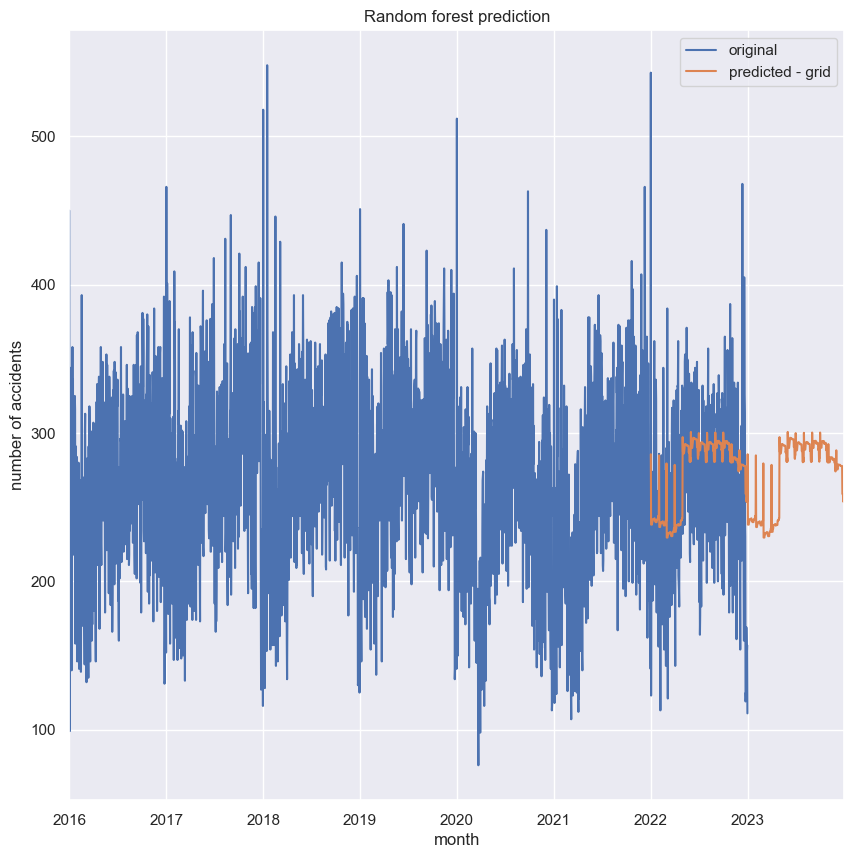

In [70]:
# plot results with random forest and grid search cv
rf_predict_df[['original', 'predicted - grid']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [71]:
# r2 score with GA search cv
rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

0.04799166612108974

In [72]:
# r2 score with randomized search cv
rf_estimator_randomized.score(X_test_ga[:periods_to_predict], y_test_ga)

0.04896449667996028

In [73]:
# r2 score with grid search cv
rf_estimator_grid.score(X_test_ga[:periods_to_predict], y_test_ga)

0.08742433529094229

Text(0, 0.5, 'number of accidents')

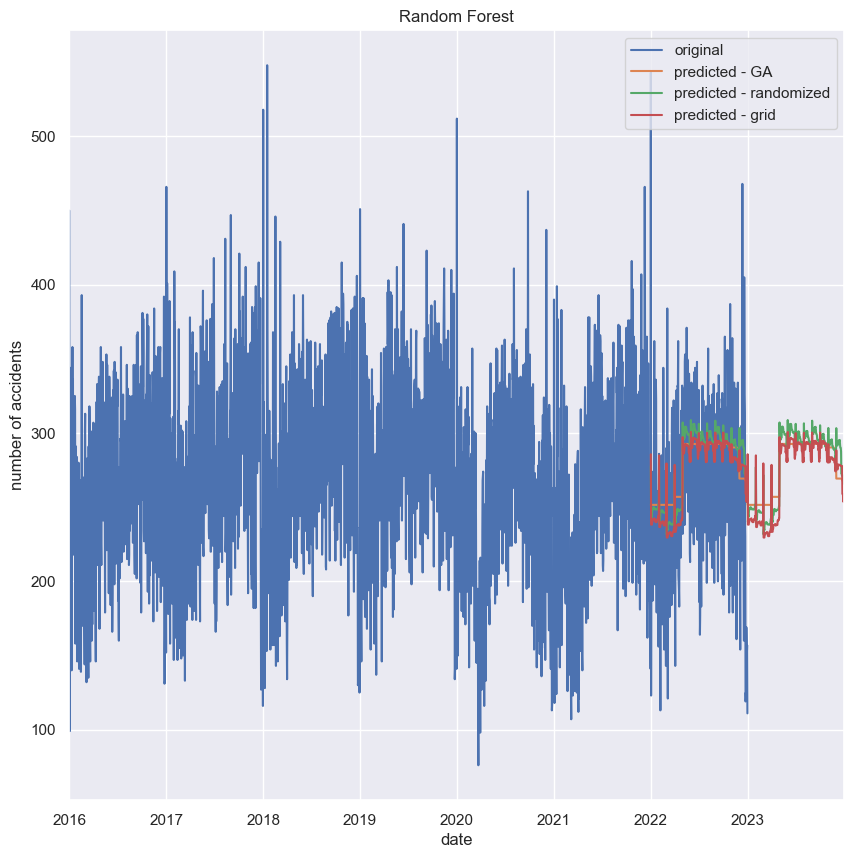

In [74]:
# plot all 3 techniques for random forest on one plot
rf_predict_df.plot()
plt.title("Random Forest")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [75]:
predict_df['random forest + GA'] = list(rf_predict_df['predicted - GA'])
predict_df['random forest + randomized'] = list(rf_predict_df['predicted - randomized'])
predict_df['random forest + grid'] = list(rf_predict_df['predicted - grid'])

predict_df

original     prophet       arima         svr     xgboost  \
ds                                                                     
2016-01-01     450.0         NaN         NaN         NaN         NaN   
2016-01-02     148.0         NaN         NaN         NaN         NaN   
2016-01-03      99.0         NaN         NaN         NaN         NaN   
2016-01-04     344.0         NaN         NaN         NaN         NaN   
2016-01-05     271.0         NaN         NaN         NaN         NaN   
...              ...         ...         ...         ...         ...   
2023-12-27       NaN  307.217432  225.791637  250.074637  172.927856   
2023-12-28       NaN  304.655051  242.064947  237.898649  155.386093   
2023-12-29       NaN  321.938731  234.417980  221.441723  147.735184   
2023-12-30       NaN  231.287019  238.109504  237.873521  153.593399   
2023-12-31       NaN  203.053664  237.921081  142.904538  111.033821   

              catboost         rnn        lstm  random forest + GA  \
ds                                                                   
2016-01-01         NaN         NaN         NaN                 NaN   
2016-01-02         NaN         NaN         NaN                 NaN   
2016-01-03         NaN         NaN         NaN                 NaN   
2016-01-04         NaN         NaN         NaN                 NaN   
2016-01-05         NaN         NaN         NaN                 NaN   
...                ...         ...         ...                 ...   
2023-12-27  160.319163  268.767261  282.694486          267.649583   
2023-12-28  158.826733  280.713473  289.123135          267.562651   
2023-12-29  153.413006  284.559181  286.678526          267.562651   
2023-12-30  157.342574  287.186995  286.718912          267.562651   
2023-12-31  108.698764  270.297127  282.750134          267.562651   

            random forest + randomized  random forest + grid  
ds                                                            
2016-01-01                         NaN                   NaN  
2016-01-02                         NaN                   NaN  
2016-01-03                         NaN                   NaN  
2016-01-04                         NaN                   NaN  
2016-01-05                         NaN                   NaN  
...                                ...                   ...  
2023-12-27                     269.685            254.500936  
2023-12-28                     265.850            253.598227  
2023-12-29                     266.565            256.575342  
2023-12-30                     266.565            256.575342  
2023-12-31                     271.610            254.255167  

[2922 rows x 11 columns]

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [77]:
# pipeline with data scaling and random forest
steps = [
    ('scaler', MinMaxScaler()),  # Data preprocessing step
    ('rf', RandomForestRegressor(random_state=111))  # Random Forest Regressor step
]

In [78]:
pipeline = Pipeline(steps)

In [79]:
# GA search cv with pipeline
rf_grid_ga = {
    'rf__n_estimators': Integer(100, 600),
    'rf__max_features': Categorical(['auto', 'sqrt', 'log2']),
    'rf__max_depth': Integer(2,20),
    'rf__criterion': Categorical(['poisson', 'squared_error', 'absolute_error', 'friedman_mse']),
    'rf__min_samples_split': Continuous(0.1, 0.9),
    'rf__bootstrap': Categorical([True, False])
}

rf_estimator_ga = GASearchCV(estimator=pipeline,
                             scoring='r2',
                             population_size=100,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=rf_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [80]:
rf_estimator_ga.fit(X_train_ga, y_train_ga)

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	100   	-0.112102	0.0917353  	0.00351394 	-0.329023  
1  	200   	-0.038198	0.0386036  	0.00351394 	-0.161973  
2  	200   	-0.0124151	0.0198899  	0.00471785 	-0.0684003 
3  	200   	-0.00258361	0.0104743  	0.00808792 	-0.061776  
4  	200   	0.00184265 	0.00221719 	0.00808792 	-0.00288172
5  	200   	0.00336001 	0.00186507 	0.00849044 	-0.0005504 
6  	200   	0.0045659  	0.00139241 	0.00832637 	0.00219044 
7  	200   	0.00548643 	0.00144726 	0.0084948  	0.00350955 
8  	200   	0.00627068 	0.00139172 	0.0084948  	0.00350955 
9  	200   	0.00752125 	0.00103524 	0.0084948  	0.00465293 
10 	200   	0.00820061 	0.000424304	0.0084948  	0.0068807  
11 	200   	0.00841968 	0.000184704	0.0084948  	0.00703763 
12 	200   	0.00849331 	3.25001e-06	0.0084948  	0.00846745 


C:\Users\katka\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000002982F2002E0>,
           error_score='raise',
           estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                     ('rf',
                                      RandomForestRegressor(criterion='poisson',
                                                            max_depth=2,
                                                            max_features='auto',
                                                            min_samples_split=0.2288410072670211,
                                                            n_estimators=511,
                                                            random_state=111))]),
           genera...
                       'rf__max_depth': <sklearn_genetic.space.space.Integer object at 0x000002984D2AC9D0>,
                       'rf__max_features': <sklearn_genetic.space.space.Categorical object at 0x000002984D2AC430>,
                       'rf__min_samples_split': <sklearn_genetic.space.space.Continuous object at 0x000002984D2AC9A0>,
                       'rf__n_estimators': <sklearn_genetic.space.space.Integer object at 0x000002984D2ACC40>},
           population_size=100, return_train_score=True, scoring='r2')

In [81]:
y_predict_rf_ga = rf_estimator_ga.predict(X_test_ga)

In [82]:
y_predict_rf_ga

array([251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56740011,
       251.56740011, 251.56740011, 251.56740011, 251.56

In [83]:
# r2 score for random forest with GA and pipeline
rf_estimator_ga.score(X_test_ga[:periods_to_predict], y_test_ga)

0.04799166612108974

In [84]:
rf_predict_df['predicted - GA - pipe'] = [None] * len(X_train_ga) + list(y_predict_rf_ga)

Text(0, 0.5, 'number of accidents')

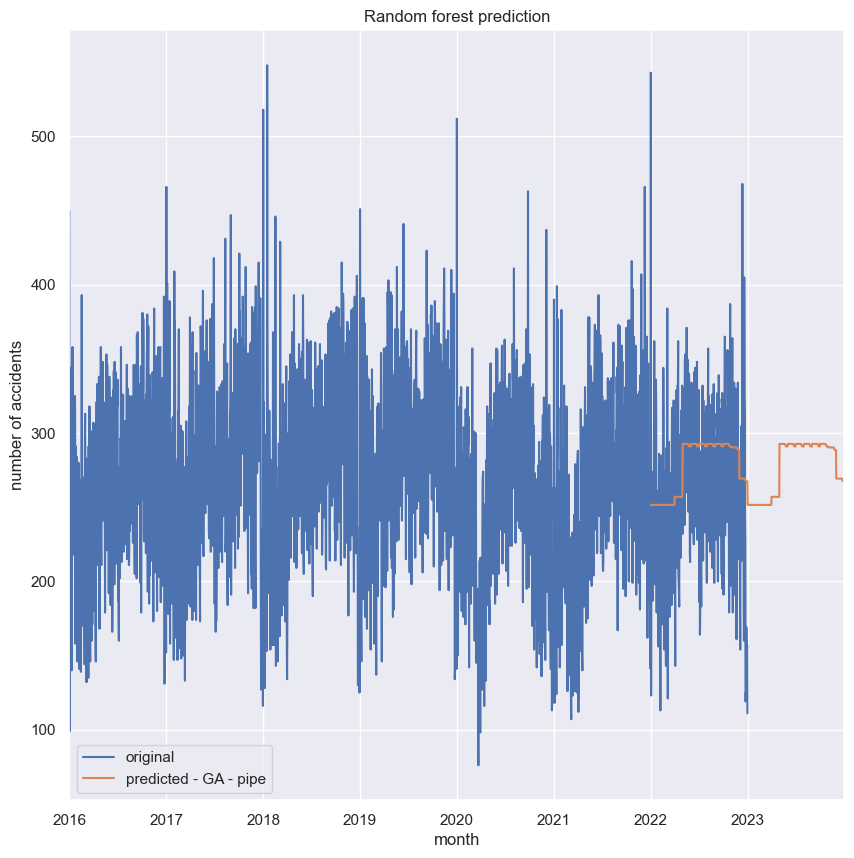

In [85]:
# plot results of random forest regressor with pipeline and GA search cv
rf_predict_df[['original', 'predicted - GA - pipe']].plot()
plt.title("Random forest prediction")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [86]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

In [87]:
mlp = MLPRegressor(random_state=111)

In [88]:
# adapters for MLP with GA search cv
mutation_adapter = ExponentialAdapter(initial_value=0.9, end_value=0.1, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.1, end_value=0.9, adaptive_rate=0.1)

In [89]:
# prepare data for MLP
scaler = StandardScaler()
scaler.fit(dataset_ga[['day', 'month', 'year', 'y']].head(len(dataset_ga) - periods_to_predict))  # fit the scaler with training data

# generate new dates
new_rows['day'] = new_rows['ds'].dt.day
new_rows['month'] = new_rows['ds'].dt.month
new_rows['year'] = new_rows['ds'].dt.year
scaled_data = dataset_df[['day', 'month', 'year', 'y']]
scaled_data = pd.concat([scaled_data, new_rows[['day', 'month', 'year']]])
scaled_data = pd.DataFrame(scaler.transform(scaled_data[['day', 'month', 'year', 'y']]), columns=['day', 'month', 'year', 'y'])

X = scaled_data[['day', 'month', 'year']]
y = scaled_data['y']

# split the scaled data to train and test set
X_train_scale = X.head(len(X) - periods_to_predict - periods_to_predict)
X_test_scale = X.tail(periods_to_predict + periods_to_predict)
y_train_scale = y.head(len(X) - periods_to_predict - periods_to_predict)
y_test_scale = y.tail(periods_to_predict + periods_to_predict)
X_train_scale.shape, X_test_scale.shape, y_train_scale.shape, y_test_scale.shape

((2192, 3), (730, 3), (2192,), (730,))

In [90]:
# hyperparameters in MLP model with GA
mlp_grid_ga = {
    "hidden_layer_sizes": Integer(5, 200), 
    "activation": Categorical(["identity", "logistic", "tanh", "relu"]), 
    "solver": Categorical(["lbfgs", "sgd", "adam"]), 
    "alpha": Continuous(0.00005, 0.05),
    "learning_rate": Categorical(["constant", "invscaling", "adaptive"]),
    "max_iter": Integer(150, 300)
}

In [91]:
mlp_estimator_ga = GASearchCV(estimator=mlp,
                             scoring='r2',
                             population_size=200,
                             generations=12,
                             mutation_probability=mutation_adapter,
                             crossover_probability=crossover_adapter,
                             param_grid=mlp_grid_ga,
                             n_jobs=-1,
                             error_score='raise'
                            )

In [92]:
mlp_estimator_ga.fit(X_train_scale, y_train_scale)

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	200   	-0.368102	0.570582   	-0.0217307 	-4.95604   
1  	400   	-0.12328 	0.0567367  	-0.0125073 	-0.491908  
2  	400   	-0.085524	0.0372699  	-0.0125073 	-0.190368  
3  	400   	-0.0633874	0.0269084  	-0.0125073 	-0.137047  
4  	400   	-0.0468745	0.0263263  	0.00767584 	-0.173578  
5  	400   	-0.0331106	0.02123    	0.00767676 	-0.188807  
6  	400   	-0.0215759	0.0134441  	0.00767676 	-0.0778903 
7  	400   	-0.012143 	0.0100653  	0.00767681 	-0.0359352 
8  	400   	-0.00389616	0.0108315  	0.00767681 	-0.0343194 
9  	400   	0.00354094 	0.00814344 	0.00767681 	-0.0125086 
10 	400   	0.00656716 	0.00459778 	0.00767681 	-0.0125076 
11 	400   	0.00767659 	2.3539e-07 	0.00767681 	0.00767584 
12 	400   	0.00767674 	1.18131e-07	0.00767682 	0.00767617 


GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x0000029830F940A0>,
           error_score='raise',
           estimator=MLPRegressor(alpha=0.0001809424542568019,
                                  hidden_layer_sizes=142,
                                  learning_rate='invscaling', max_iter=222,
                                  random_state=111, solver='sgd'),
           generations=12,
           mutation_probability=<sklearn_genetic.schedules.sched...
                       'hidden_layer_sizes': <sklearn_genetic.space.space.Integer object at 0x000002984CD79040>,
                       'learning_rate': <sklearn_genetic.space.space.Categorical object at 0x000002984CD8AC40>,
                       'max_iter': <sklearn_genetic.space.space.Integer object at 0x000002984CD8A820>,
                       'solver': <sklearn_genetic.space.space.Categorical object at 0x0000029814595730>},
           population_size=200, return_train_score=True, scoring='r2')

In [93]:
mlp_estimator_ga.best_params_

{'hidden_layer_sizes': 142,
 'activation': 'relu',
 'solver': 'sgd',
 'alpha': 0.0001809424542568019,
 'learning_rate': 'invscaling',
 'max_iter': 222}

In [94]:
y_predict_mlp_ga = mlp_estimator_ga.predict(X_test_scale)
y_predict_mlp_ga

array([-0.13632379, -0.14809644, -0.16238665, -0.17752345, -0.1932242 ,
       -0.205915  , -0.21806472, -0.22867592, -0.23684603, -0.24213742,
       -0.24627893, -0.24779561, -0.24337134, -0.23770676, -0.23644028,
       -0.23949611, -0.24146944, -0.24163198, -0.23894893, -0.23541219,
       -0.23096346, -0.23055025, -0.23069011, -0.22743029, -0.22321327,
       -0.2192285 , -0.21629182, -0.21364409, -0.21002066, -0.20518067,
       -0.19996912, -0.10567404, -0.12357554, -0.1363014 , -0.15079695,
       -0.16242989, -0.17605838, -0.18681189, -0.19633997, -0.20532484,
       -0.21365507, -0.21798487, -0.22138391, -0.22362007, -0.22285335,
       -0.22262597, -0.22642327, -0.22477013, -0.22397428, -0.22023744,
       -0.21723689, -0.21780471, -0.21728707, -0.21183491, -0.20765738,
       -0.20490621, -0.20290124, -0.20101741, -0.19751466, -0.07327375,
       -0.08905191, -0.10321524, -0.11540732, -0.12804626, -0.14068521,
       -0.15287306, -0.16568402, -0.17758635, -0.1847313 , -0.19

In [95]:
# r2 score for MLP with GA
mlp_estimator_ga.score(X_test_scale.head(periods_to_predict), y_test_scale.head(periods_to_predict))

0.011723096813036515

In [96]:
# create dataframe with forecast (MLP + GA)
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_ga.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_4984\3139332339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_ga.tolist()


day  month    year           y
0     1.0    1.0  2022.0  269.130945
1     2.0    1.0  2022.0  268.373935
2     3.0    1.0  2022.0  267.455039
3     4.0    1.0  2022.0  266.481707
4     5.0    1.0  2022.0  265.472110
..    ...    ...     ...         ...
725  27.0   12.0  2023.0  264.394398
726  28.0   12.0  2023.0  263.351503
727  29.0   12.0  2023.0  262.255361
728  30.0   12.0  2023.0  261.189009
729  31.0   12.0  2023.0  260.222573

[730 rows x 4 columns]

Text(0, 0.5, 'number of accidents')

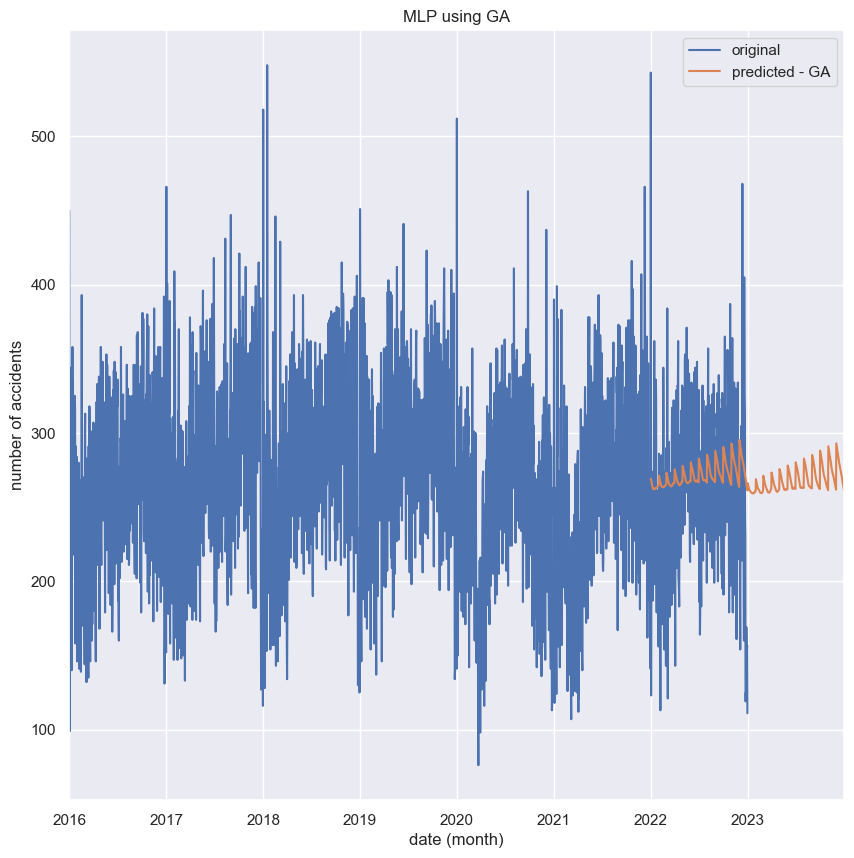

In [97]:
mlp_predict_df = pd.concat([dataset_df[['ds']], new_rows[['ds']]], ignore_index=True)  # add results to predict_df

mlp_predict_df['original'] = list(dataset_df['y']) + [None] * periods_to_predict
mlp_predict_df['predicted - GA'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df.set_index('ds', inplace=True)
mlp_predict_df.plot()  # plot results of MLP with GA
plt.title("MLP using GA")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

C:\Users\katka\anaconda3\lib\site-packages\sklearn_genetic\plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

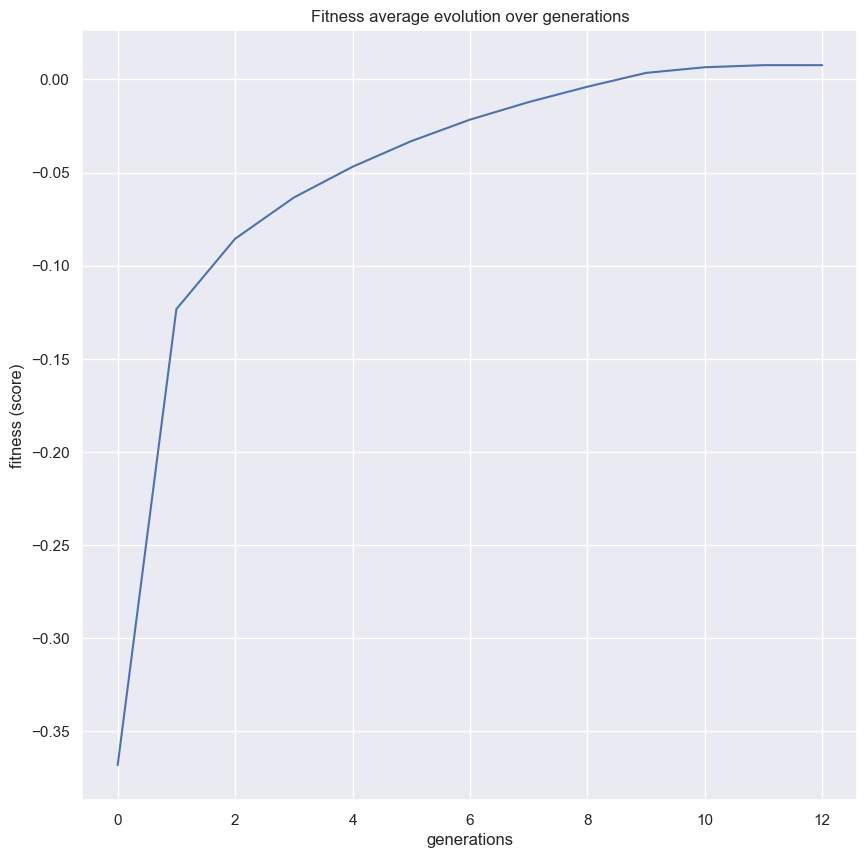

In [98]:
plot_fitness_evolution(mlp_estimator_ga)

In [99]:
# grid for MLP and Randomized search CV
mlp_grid_randomized = {
    "hidden_layer_sizes": [10, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}


In [100]:
from sklearn.model_selection import RandomizedSearchCV

In [101]:
mlp_estimator_randomized = RandomizedSearchCV(estimator=mlp,
                                             scoring='neg_root_mean_squared_error',
                                             param_distributions = mlp_grid_randomized,
                                             n_jobs=-1,
                                             error_score='raise',
                                             random_state=111
                                            )

In [102]:
mlp_estimator_randomized.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(error_score='raise',
                   estimator=MLPRegressor(alpha=0.0001809424542568019,
                                          hidden_layer_sizes=142,
                                          learning_rate='invscaling',
                                          max_iter=222, random_state=111,
                                          solver='sgd'),
                   n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [5e-05, 0.05],
                                        'hidden_layer_sizes': [10, 500],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [150, 300],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=111, scoring='neg_root_mean_squared_error')

In [103]:
mlp_estimator_randomized.best_params_

{'solver': 'adam',
 'max_iter': 150,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': 500,
 'alpha': 5e-05,
 'activation': 'relu'}

In [104]:
y_predict_mlp_randomized = mlp_estimator_randomized.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_randomized

array([-0.26281363, -0.31575866, -0.35437923, -0.34876639, -0.31074664,
       -0.27261031, -0.23527681, -0.1981897 , -0.16067947, -0.12339369,
       -0.08774657, -0.07841194, -0.07837669, -0.08904087, -0.10855229,
       -0.12716342, -0.15291878, -0.18099449, -0.20009934, -0.21917622,
       -0.23744014, -0.25342534, -0.26283699, -0.26517149, -0.25817562,
       -0.24405187, -0.22667676, -0.20524074, -0.18201976, -0.15898216,
       -0.13633627, -0.45584635, -0.507592  , -0.53275354, -0.53184989,
       -0.52579493, -0.50360318, -0.46191882, -0.42088755, -0.38227806,
       -0.34505267, -0.31077186, -0.29820744, -0.28615461, -0.28735766,
       -0.29641276, -0.30117022, -0.30595751, -0.31754298, -0.33019   ,
       -0.34701539, -0.36149292, -0.36669175, -0.36937589, -0.36930139,
       -0.36464559, -0.34893476, -0.32836551, -0.30777514, -0.59205461,
       -0.64298581, -0.65932203, -0.66390346, -0.65778315, -0.65041094,
       -0.63682257, -0.59077724, -0.54099761, -0.49050694, -0.44

In [105]:
# r2 score for MLP regressor with randomized search cv
mlp_estimator_randomized.score(X_test_scale[['day', 'month', 'year']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

-1.0006343897058603

In [106]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_4984\2992247175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_randomized.tolist()


day  month    year           y
0     1.0    1.0  2022.0  260.997339
1     2.0    1.0  2022.0  257.592845
2     3.0    1.0  2022.0  255.109448
3     4.0    1.0  2022.0  255.470367
4     5.0    1.0  2022.0  257.915130
..    ...    ...     ...         ...
725  27.0   12.0  2023.0  267.399202
726  28.0   12.0  2023.0  262.705091
727  29.0   12.0  2023.0  257.847951
728  30.0   12.0  2023.0  252.328838
729  31.0   12.0  2023.0  246.271610

[730 rows x 4 columns]

Text(0, 0.5, 'number of accidents')

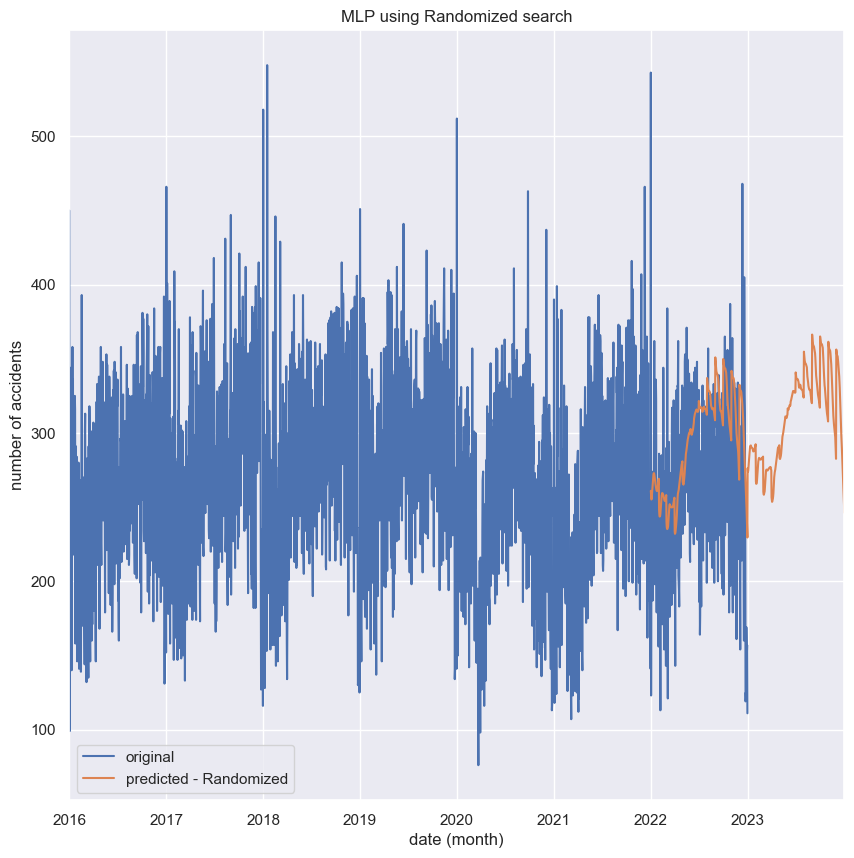

In [107]:
# plot predicted values from MLP model with randomized search cv
mlp_predict_df['predicted - Randomized'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Randomized']].plot()
plt.title("MLP using Randomized search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [108]:
# grid for MLP and Grid search CV
mlp_grid = {
    "hidden_layer_sizes": [10, 250, 500], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": [0.00005, 0.005, 0.05],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [150, 300]
}

In [109]:
mlp_estimator_grid = GridSearchCV(estimator=mlp,
                                  scoring='neg_root_mean_squared_error',
                                  param_grid = mlp_grid_randomized,
                                  n_jobs=-1,
                                  error_score='raise'
                                 )

In [110]:
mlp_estimator_grid.fit(X_train_scale, y_train_scale)

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(error_score='raise',
             estimator=MLPRegressor(alpha=0.0001809424542568019,
                                    hidden_layer_sizes=142,
                                    learning_rate='invscaling', max_iter=222,
                                    random_state=111, solver='sgd'),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [5e-05, 0.05],
                         'hidden_layer_sizes': [10, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [150, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='neg_root_mean_squared_error')

In [111]:
mlp_estimator_grid.best_params_

{'activation': 'tanh',
 'alpha': 5e-05,
 'hidden_layer_sizes': 10,
 'learning_rate': 'constant',
 'max_iter': 300,
 'solver': 'adam'}

In [112]:
y_predict_mlp_grid = mlp_estimator_grid.predict(X_test_scale[['day', 'month', 'year']])
y_predict_mlp_grid

array([-9.12844018e-01, -9.00645571e-01, -8.88439377e-01, -8.76267361e-01,
       -8.64174550e-01, -8.52209056e-01, -8.40422006e-01, -8.28867390e-01,
       -8.17601833e-01, -8.06684233e-01, -7.96175277e-01, -7.86136777e-01,
       -7.76630810e-01, -7.67718629e-01, -7.59459305e-01, -7.51908094e-01,
       -7.45114493e-01, -7.39120018e-01, -7.33955725e-01, -7.29639553e-01,
       -7.26173624e-01, -7.23541674e-01, -7.21706864e-01, -7.20610260e-01,
       -7.20170279e-01, -7.20283389e-01, -7.20826233e-01, -7.21659180e-01,
       -7.22631058e-01, -7.23584567e-01, -7.24361638e-01, -9.29955533e-01,
       -9.15605684e-01, -9.01099921e-01, -8.86466411e-01, -8.71735071e-01,
       -8.56937474e-01, -8.42106715e-01, -8.27277218e-01, -8.12484482e-01,
       -7.97764742e-01, -7.83154535e-01, -7.68690154e-01, -7.54406974e-01,
       -7.40338640e-01, -7.26516107e-01, -7.12966548e-01, -6.99712154e-01,
       -6.86768877e-01, -6.74145209e-01, -6.61841117e-01, -6.49847290e-01,
       -6.38144904e-01, -

In [113]:
# r2 score for MLP regressor with grid search cv
mlp_estimator_grid.score(X_test_scale[['day', 'month', 'year']].head(periods_to_predict), y_test_scale.head(periods_to_predict))

-0.9620842010396214

In [114]:
# add forecasted values to a dataframe
predictions_unscaled = X_test_scale
predictions_unscaled['y'] = y_predict_mlp_grid.tolist()
predictions_unscaled = pd.DataFrame(scaler.inverse_transform(predictions_unscaled), columns=['day', 'month', 'year', 'y'])
predictions_unscaled

C:\Users\katka\AppData\Local\Temp\ipykernel_4984\1944907383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_unscaled['y'] = y_predict_mlp_grid.tolist()


day  month    year           y
0     1.0    1.0  2022.0  219.198798
1     2.0    1.0  2022.0  219.983188
2     3.0    1.0  2022.0  220.768076
3     4.0    1.0  2022.0  221.550766
4     5.0    1.0  2022.0  222.328363
..    ...    ...     ...         ...
725  27.0   12.0  2023.0  291.033243
726  28.0   12.0  2023.0  287.755072
727  29.0   12.0  2023.0  284.388324
728  30.0   12.0  2023.0  280.957935
729  31.0   12.0  2023.0  277.490003

[730 rows x 4 columns]

Text(0, 0.5, 'number of accidents')

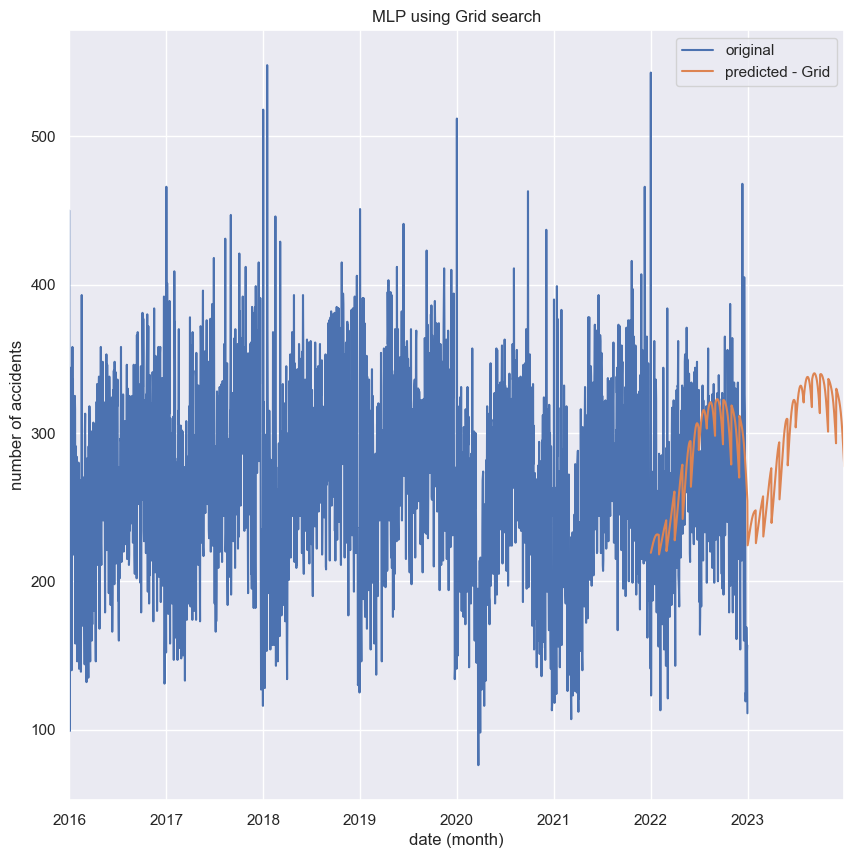

In [115]:
# plot predicted values from MLP model with grid search cv
mlp_predict_df['predicted - Grid'] = [None] * (len(mlp_predict_df) - periods_to_predict - periods_to_predict) + list(predictions_unscaled['y'])
mlp_predict_df[['original', 'predicted - Grid']].plot()
plt.title("MLP using Grid search")
plt.xlabel("date (month)")
plt.ylabel("number of accidents")

In [116]:
predict_df['MLP + GA'] = list(mlp_predict_df['predicted - GA'])
predict_df['MLP + randomized'] = list(mlp_predict_df['predicted - Randomized'])
predict_df['MLP + grid'] = list(mlp_predict_df['predicted - Grid'])

predict_df

original     prophet       arima         svr     xgboost  \
ds                                                                     
2016-01-01     450.0         NaN         NaN         NaN         NaN   
2016-01-02     148.0         NaN         NaN         NaN         NaN   
2016-01-03      99.0         NaN         NaN         NaN         NaN   
2016-01-04     344.0         NaN         NaN         NaN         NaN   
2016-01-05     271.0         NaN         NaN         NaN         NaN   
...              ...         ...         ...         ...         ...   
2023-12-27       NaN  307.217432  225.791637  250.074637  172.927856   
2023-12-28       NaN  304.655051  242.064947  237.898649  155.386093   
2023-12-29       NaN  321.938731  234.417980  221.441723  147.735184   
2023-12-30       NaN  231.287019  238.109504  237.873521  153.593399   
2023-12-31       NaN  203.053664  237.921081  142.904538  111.033821   

              catboost         rnn        lstm  random forest + GA  \
ds                                                                   
2016-01-01         NaN         NaN         NaN                 NaN   
2016-01-02         NaN         NaN         NaN                 NaN   
2016-01-03         NaN         NaN         NaN                 NaN   
2016-01-04         NaN         NaN         NaN                 NaN   
2016-01-05         NaN         NaN         NaN                 NaN   
...                ...         ...         ...                 ...   
2023-12-27  160.319163  268.767261  282.694486          267.649583   
2023-12-28  158.826733  280.713473  289.123135          267.562651   
2023-12-29  153.413006  284.559181  286.678526          267.562651   
2023-12-30  157.342574  287.186995  286.718912          267.562651   
2023-12-31  108.698764  270.297127  282.750134          267.562651   

            random forest + randomized  random forest + grid    MLP + GA  \
ds                                                                         
2016-01-01                         NaN                   NaN         NaN   
2016-01-02                         NaN                   NaN         NaN   
2016-01-03                         NaN                   NaN         NaN   
2016-01-04                         NaN                   NaN         NaN   
2016-01-05                         NaN                   NaN         NaN   
...                                ...                   ...         ...   
2023-12-27                     269.685            254.500936  264.394398   
2023-12-28                     265.850            253.598227  263.351503   
2023-12-29                     266.565            256.575342  262.255361   
2023-12-30                     266.565            256.575342  261.189009   
2023-12-31                     271.610            254.255167  260.222573   

            MLP + randomized  MLP + grid  
ds                                        
2016-01-01               NaN         NaN  
2016-01-02               NaN         NaN  
2016-01-03               NaN         NaN  
2016-01-04               NaN         NaN  
2016-01-05               NaN         NaN  
...                      ...         ...  
2023-12-27        267.399202  291.033243  
2023-12-28        262.705091  287.755072  
2023-12-29        257.847951  284.388324  
2023-12-30        252.328838  280.957935  
2023-12-31        246.271610  277.490003  

[2922 rows x 14 columns]

In [179]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [183]:
def create_graph_dataset(dataframe, num_neighbors=21):
    ds_values = pd.to_datetime(dataframe['ds']).values.astype(float)
    y_values = dataframe['y'].values.astype(float)

    x = torch.tensor(y_values, dtype=torch.float32).view(-1, 1)
    edge_index = torch.zeros((2, 0), dtype=torch.long)

    for i in range(len(ds_values)):
        # num_neighbors nearest timestamps will be edges
        start = max(0, i - num_neighbors)
        end = min(len(ds_values), i + num_neighbors + 1)
        neighbors = list(range(start, i)) + list(range(i + 1, end))
        edges = torch.tensor([[i] * len(neighbors), neighbors], dtype=torch.long)
        edge_index = torch.cat([edge_index, edges], dim=1)

    return Data(x=x, edge_index=edge_index)

# create a graph dataset from the DataFrame with train and test data
train_dataset = create_graph_dataset(dataset_train)
test_dataset = create_graph_dataset(dataset_test)

# create data loaders for training and testing
train_loader = DataLoader([train_dataset], batch_size=64)
test_loader = DataLoader([test_dataset], batch_size=64)

In [184]:
# define the GNN model
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TimeSeriesGNN, self).__init__()
        torch.manual_seed(111)
        self.conv1 = GCNConv(in_channels, hidden_channels)  # first layer
        self.conv2 = GCNConv(hidden_channels, out_channels)  # second layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # first GCN layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # second GCN layer
        x = self.conv2(x, edge_index)
        
        return x

# dimensions used for the GNN
input_dim = 1  # dimension of node features
hidden_dim = 64
output_dim = 1  # dimension of the predicted output

gnn_model = TimeSeriesGNN(input_dim, hidden_dim, output_dim)  # create the GNN model

loss_fn = nn.MSELoss()  # loss function used for regression

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)  # optimizer used for regression

# train the model using the DataLoader object
num_epochs = 500
for epoch in range(num_epochs):
    gnn_model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gnn_model(data)
        loss = loss_fn(output, data.x)
        loss.backward()
        optimizer.step()

# make predictions
gnn_model.eval()
for data in test_loader:
    output = gnn_model(data)
    print(output)
    predict_df['GNN'] = [None] * len(dataset_train) + output.flatten().tolist() + [None] * periods_to_predict

tensor([[202.5602],
        [206.2007],
        [209.8581],
        [213.4298],
        [216.9030],
        [220.3663],
        [223.7597],
        [227.0387],
        [230.2253],
        [233.3728],
        [236.4160],
        [239.4047],
        [242.3468],
        [245.2123],
        [247.9084],
        [250.5173],
        [253.1210],
        [255.6862],
        [258.2119],
        [260.7026],
        [263.1933],
        [265.5847],
        [263.8329],
        [262.2313],
        [260.6958],
        [259.2500],
        [257.9161],
        [256.6278],
        [255.3280],
        [254.0709],
        [252.9644],
        [251.8801],
        [250.7757],
        [249.6788],
        [248.6147],
        [247.5398],
        [246.5481],
        [245.7568],
        [244.9763],
        [244.2867],
        [243.6553],
        [243.0574],
        [242.4247],
        [241.8180],
        [241.6099],
        [241.3421],
        [241.1008],
        [240.8851],
        [240.6003],
        [240.2647],


In [122]:
from autots import AutoTS

In [123]:
autots_model = AutoTS(forecast_length=periods_to_predict)
autots_model = autots_model.fit(dataset_train, date_col='ds', value_col='y', id_col=None)

Inferred frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
58/58 [==============================] - 11s 8ms/step - loss: 0.3642
Epoch 2/50
58/58 [==============================] - 0s 8ms/step - loss: 0.3136
Epoch 3/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2947
Epoch 4/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2834
Epoch 5/50
58/58 [==============================] - 1s 9ms/step - loss: 0.2740
Epoch 6/50
58/58 [==============================] - 1s 10ms/step - loss: 0.2636
Epoch 7/50
58/58 [==============================] - 1s 9ms/step - loss: 0.2593
Epoch 8/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2661
Epoch 9/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2536
Epoch 10/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2548
Epoch 11/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2519
Epoch 12/50
58/58 [==============================] - 1s 9ms

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 36 with model FBProphet in generation 0 of 10


21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model

21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10
Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Model Number: 61 with model ARCH in generation 0 of 10
Model Number: 62 with model ConstantNaive in generation 0 of 10
Model Number: 63 with model LastValueNaive in generation 0 of 10
Model Number: 64 with model AverageValueNaive in generation 0 of 10
Model Number: 65 with model GLS in generation 0 of 10
Model Number: 66 with model SeasonalNaive in generation 0 of 10
Model Number: 67 with model GLM in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 68 with model ETS in generation 0 of 10
Model Number: 69 with model FBProphet in generation 0 of 10


21:55:40 - cmdstanpy - INFO - Chain [1] start processing
21:55:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 70 in generation 0: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72 in generation 0: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 73 in generation 0: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 74 in generation 0: ARIMA
Model Number: 75 with model WindowRegression in generation 0 of 10
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User'

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 106 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipOutliers', '1': 'Detrend', '2': 'cffilter', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 5, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 106 in generation 0: ETS
Model Number: 107 with model UnobservedComponents in generation 0 of 10
Model Number: 108 with model NVAR in generation 0 of 10
Model Number: 109 with model Gluo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 113 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 113 in generation 0: VAR
Model Number: 114 with model ETS in generation 0 of 10
Model Number: 115 with model ETS in generation 0 of 10
Model Number: 116 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 116 in generation 0: UnobservedComponents
Model Number: 117 with model ETS in generation 0 of 10
Model Number: 118 with model SeasonalNaive in generation 0 of 10
Model Number: 119 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 119 in generation 0: ARIMA
Model Number: 120 with model SeasonalNaive in generation 0 of 10
Model Number: 121 with model GLS in generation 0 of 10
Model Number: 122 with model UnivariateMotif in generation 0 of 10
Model Number: 123 with model V

C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+01, tolerance: 3.285e-03
  model = cd_fast.enet_coordinate_descent(


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 139 in generation 0: ETS
Model Number: 140 with model ConstantNaive in generation 0 of 10
Model Number: 141 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 141 in generation 0: MultivariateRegression
Model Number: 142 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 142 in generation 0: VAR
Model Number: 143 with model NVAR in generation 0 of 10
Model Number: 144 with model SeasonalNaive in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 144 in generation 0: SeasonalNaive
Model Number: 145 with model LastValueNaive in generation 0 of 10
Model Number: 146 with model LastValueNaive in generation 0 of 10
Model Number: 147 with model FBProphet in generation 0 of 10


21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 148 with model LastValueNaive in generation 0 of 10
Model Number: 149 with model SeasonalNaive in generation 0 of 10
Model Number: 150 with model NVAR in generation 0 of 10
Model Number: 151 with model MultivariateRegression in generation 0 of 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Template Eval Error: LightGBMError('[poisson]: at least one target label is negative') in model 151 in generation 0: MultivariateRegression
Model Number: 152 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 152 in generation 0: VECM
Model Number: 153 with model NVAR in generation 0 of 10
Model Number: 154 with model AverageValueNaive in generation 0 of 10
Model Number: 155 with model ARCH in generation 0 of 10
M

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 168 with model LastValueNaive in generation 0 of 10
Model Number: 169 with model AverageValueNaive in generation 0 of 10
Model Number: 170 with model UnivariateMotif in generation 0 of 10
Model Number: 171 with model Theta in generation 0 of 10
Model Number: 172 with model GLM in generation 0 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 173 with model MultivariateMotif in generation 0 of 10
Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model ARDL in generation 0 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 175 in generation 0: ARDL
Model Number: 176 with model DatepartRegression in generation 0 of 10
Model Number: 177 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 177 in generation 0: UnobservedComponents
Model Number: 178 with model UnobservedComponents in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 178 in generation 0: UnobservedComponents
Model Number: 179 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue.') in model 179 in gen

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 191 with model NVAR in generation 1 of 10
Model Number: 192 with model AverageValueNaive in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 193 with model FBProphet in generation 1 of 10


21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 194 with model DatepartRegression in generation 1 of 10
Model Number: 195 with model FBProphet in generation 1 of 10


21:58:41 - cmdstanpy - INFO - Chain [1] start processing
21:58:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 196 with model NVAR in generation 1 of 10
Model Number: 197 with model MultivariateMotif in generation 1 of 10
Model Number: 198 with model UnobservedComponents in generation 1 of 10
Model Number: 199 with model WindowRegression in generation 1 of 10
Model Number: 200 with model Theta in generation 1 of 10
Model Number: 201 with model AverageValueNaive in generation 1 of 10
Model Number: 202 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 203 with model GLS in generation 1 of 10
Model Number: 204 with model LastValueNaive in generation 1 of 10
Model Number: 205 with model SeasonalNaive in generation 1 of 10
Model Number: 206 with model GLM in generation 1 of 10
Model Number: 207 with model GLS in generation 1 of 10
Model Number: 208 with mo

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 209 with model DatepartRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 209 in generation 1: DatepartRegression
Model Number: 210 with model UnivariateMotif in generation 1 of 10
Model Number: 211 with model UnobservedComponents in generation 1 of 10
Model Number: 212 with model UnivariateMotif in generation 1 of 10
Model Number: 213 with model MultivariateMotif in generation 1 of 10
Model Number: 214 with model AverageValueNaive in generation 1 of 10
Model Number: 215 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 216 with model ARDL in generation 1 of 10
Model Number: 217 with model SeasonalNaive in generation 1 of 10
Model Number: 218 with model AverageVal

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 225 with model DatepartRegression in generation 1 of 10
Model Number: 226 with model GLS in generation 1 of 10
Model Number: 227 with model ARDL in generation 1 of 10
Model Number: 228 with model AverageValueNaive in generation 1 of 10
Model Number: 229 with model SeasonalNaive in generation 1 of 10
Model Number: 230 with model ConstantNaive in generation 1 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 230 in generation 1: ConstantNaive
Model Number: 231 with model ConstantNaive in generation 1 of 10
Model Number: 232 with model SeasonalNaive in generation 1 of 10
Model Number: 233 with model SectionalMotif in generation 1 of 10
Model Number: 234 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 235 with m

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Input X contains NaN.\nRadiusNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 235 in generation 1: MultivariateRegression
Model Number: 236 with model GLM in generation 1 of 10
Model Number: 237 with model GLM in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:325: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:775: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:813: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.va

Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 237 in generation 1: GLM
Model Number: 238 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 239 with model UnivariateMotif in generation 1 of 10
Model Number: 240 with model AverageValueNaive in generation 1 of 10
Model Number: 241 with model SectionalMotif in generation 1 of 10
Model Number: 242 with model UnivariateMotif in generation 1 of 10
Model Number: 243 with model FBProphet in generation 1 of 10


22:00:00 - cmdstanpy - INFO - Chain [1] start processing
22:00:01 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 244 with model ConstantNaive in generation 1 of 10
Model Number: 245 with model NVAR in generation 1 of 10
Model Number: 246 with model NVAR in generation 1 of 10
Model Number: 247 with model UnivariateMotif in generation 1 of 10
Model Number: 248 with model MultivariateRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 249 with model WindowRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 249 in generation 1: WindowRegression
Model Number: 250 with model GLS in generation 1 of 10
Model Number: 251 with model UnobservedComponents in generation 1 of 10
Model Number: 252 with model UnobservedComponents in generation 1 of 10
Model Number: 253 with model SeasonalNaive in generation 1 of 10
Model Number: 254 with model FBProphet in generation 1 of 10


22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:26 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 255 with model SectionalMotif in generation 1 of 10
Model Number: 256 with model SeasonalNaive in generation 1 of 10
Model Number: 257 with model ConstantNaive in generation 1 of 10
Model Number: 258 with model GLS in generation 1 of 10
Model Number: 259 with model MultivariateMotif in generation 1 of 10
Model Number: 260 with model GLS in generation 1 of 10
Model Number: 261 with model LastValueNaive in generation 1 of 10
Model Number: 262 with model UnivariateMotif in generation 1 of 10
Model Number: 263 with model LastValueNaive in generation 1 of 10
Model Number: 264 with model UnivariateMotif in generation 1 of 10
Model Number: 265 with model AverageValueNaive in generation 1 of 10
Model Number: 266 with model UnivariateMotif in generation 1 of 10
Model Number: 267 with model LastValueNaive in generation 1 of 10
Model Number: 268 with model GLM in generation 1 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 270 with model ARDL in generation 1 of 10
Model Number: 271 with model DatepartRegression in generation 1 of 10
Epoch 1/50
58/58 [==============================] - 15s 14ms/step - loss: 0.0620
Epoch 2/50
58/58 [==============================] - 1s 14ms/step - loss: 0.0415
Epoch 3/50
58/58 [==============================] - 1s 13ms/step - loss: 0.0407
Epoch 4/50
58/58 [==============================] - 1s 13ms/step - loss: 0.0393
Epoch 5/50
58/58 [==============================] - 1s 15ms/step - loss: 0.0379
Epoch 6/50
58/58 [==============================] - 1s 17ms/step - loss: 0.0385
Epoch 7/50
58/58 [==============================] - 1s 14ms/step - loss: 0.0373
Epoch 8/50
58/58 [==============================] - 1s 15ms/step - loss: 0.0368
Epoch 9/50
58/58 [==============================] - 1s 14ms/step - loss: 0.0360
Epoch 10/50
58/58 [==============================] - 1s 14ms/step - loss: 0.0364
Epoch 11/50
58/58 [==============================] - 1s 14ms/step - loss

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 279 with model SeasonalNaive in generation 1 of 10
Model Number: 280 with model ARDL in generation 1 of 10
Model Number: 281 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 282 with model DatepartRegression in generation 1 of 10
Model Number: 283 with model AverageValueNaive in generation 1 of 10
Model Number: 284 with model Theta in generation 1 of 10
Model Number: 285 with model MultivariateMotif in generation 1 of 10
Model Number: 286 with model MultivariateMotif in generation 1 of 10
Model Number: 287 with model GLM in generation 1 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 287 in generation 1: GLM
Model Number: 288

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 289 with model GLS in generation 1 of 10
Model Number: 290 with model AverageValueNaive in generation 1 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 290 in generation 1: AverageValueNaive
Model Number: 291 with model DatepartRegression in generation 1 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 292 with model ConstantNaive in generation 1 of 10
Model Number: 293 with model ARIMA in generation 1 of 10
Model Number: 294 with model NVAR in generation 1 of 10
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 294 in generation 1: NVAR
Model Number: 295 with model SectionalMotif in generation 1 of 10
Model Number: 296 with model Theta in generation 1 of 10
Model Number: 297 with model GLS in generation 1 of 10
Model Number: 298 with model FBProphet in generation 1 of 10


22:02:18 - cmdstanpy - INFO - Chain [1] start processing
22:02:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 299 with model UnobservedComponents in generation 1 of 10
Model Number: 300 with model ETS in generation 1 of 10
Model Number: 301 with model SeasonalNaive in generation 1 of 10
Model Number: 302 with model AverageValueNaive in generation 1 of 10
Model Number: 303 with model ConstantNaive in generation 1 of 10
Model Number: 304 with model MultivariateRegression in generation 1 of 10
Model Number: 305 with model MultivariateMotif in generation 1 of 10
Model Number: 306 with model SeasonalNaive in generation 1 of 10
Model Number: 307 with model DatepartRegression in generation 1 of 10
Model Number: 308 with model GLM in generation 1 of 10
Model Number: 309 with model ETS in generation 1 of 10
Model Number: 310 with model MultivariateRegression in generation 1 of 10
Model Number: 311 with model SectionalMotif in generation 1 of 10
New Generation: 2 of 10
Model Number: 312 with model ConstantNaive in generation 2 of 10
Model Number: 313 with model AverageValueNaive in generat

22:03:45 - cmdstanpy - INFO - Chain [1] start processing
22:03:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 315 with model LastValueNaive in generation 2 of 10
Model Number: 316 with model FBProphet in generation 2 of 10


22:03:50 - cmdstanpy - INFO - Chain [1] start processing
22:03:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 317 with model UnivariateMotif in generation 2 of 10
Model Number: 318 with model DatepartRegression in generation 2 of 10
Epoch 1/50
58/58 [==============================] - 10s 14ms/step - loss: 274693013504.0000
Epoch 2/50
58/58 [==============================] - 1s 14ms/step - loss: 274692997120.0000
Epoch 3/50
58/58 [==============================] - 1s 13ms/step - loss: 274692947968.0000
Epoch 4/50
58/58 [==============================] - 1s 13ms/step - loss: 274693013504.0000
Epoch 5/50
58/58 [==============================] - 1s 13ms/step - loss: 274692964352.0000
Epoch 6/50
58/58 [==============================] - 1s 15ms/step - loss: 274692997120.0000
Epoch 7/50
58/58 [==============================] - 1s 12ms/step - loss: 274692931584.0000
Epoch 8/50
58/58 [==============================] - 1s 14ms/step - loss: 274692849664.0000
Epoch 9/50
58/58 [==============================] - 1s 12ms/step - loss: 274692947968.0000
Epoch 10/50
58/58 [========================

22:04:38 - cmdstanpy - INFO - Chain [1] start processing
22:04:38 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 323 with model MultivariateMotif in generation 2 of 10
Model Number: 324 with model WindowRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 324 in generation 2: WindowRegression
Model Number: 325 with model UnivariateMotif in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 325 in generation 2: UnivariateMotif
Model Number: 326 with model GLM in generation 2 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 326 in generation 2: GLM
Model Number: 327 with model UnobservedComponents in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 328 with model UnivariateMotif in generation 2 of 10
Model Number: 329 with model GLM in generation 2 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 329 in generation 2: GLM
Model Number: 330 with model AverageValueNaive in generation 2 of 10
Model Number: 331 with model WindowRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 332 with model GLM in generation 2 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 332 in generation 2: GLM
Model Number: 333 with model AverageValueNaive in generation 2 of 10
Model Number: 334 with model UnivariateMotif in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 335 with model LastValueNaive in generation 2 of 10
Model Number: 336 with model DatepartRegression in generation 2 of 10
Model Number: 337 with model ConstantNaive in generation 2 of 10
Model Number: 338 with model MultivariateMotif in generation 2 of 10
Model Number: 339 with model LastValueNaive in generation 2 of 10
Model Number: 340 with model DatepartRegression in generation 2 of 10
Model Number: 341 with model MultivariateRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 341 in generation 2: MultivariateRegression
Model Number: 342 with model GLS in generation 2 of 10
Model Number: 343 with model GLM in generation 2 of 10
Model Number: 344 with model NVAR in generation 2 of 10
Model Number: 345 with model GLS in generation 2 of 10
Model Number: 346 with model Theta in generation 2 of 10
Model Number: 347 with model NVAR in generation 2 of 10
Model Number: 348 with model FBProphet i

22:05:15 - cmdstanpy - INFO - Chain [1] start processing
22:05:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 349 with model AverageValueNaive in generation 2 of 10
Model Number: 350 with model FBProphet in generation 2 of 10


22:05:17 - cmdstanpy - INFO - Chain [1] start processing
22:05:17 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 351 with model GLS in generation 2 of 10
Model Number: 352 with model NVAR in generation 2 of 10
Model Number: 353 with model ConstantNaive in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 353 in generation 2: ConstantNaive
Model Number: 354 with model SeasonalNaive in generation 2 of 10
Model Number: 355 with model ARIMA in generation 2 of 10
Model Number: 356 with model FBProphet in generation 2 of 10
No anomalies detected.


22:05:25 - cmdstanpy - INFO - Chain [1] start processing
22:05:25 - cmdstanpy - INFO - Chain [1] done processing
22:05:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
22:05:26 - cmdstanpy - INFO - Chain [1] start processing
22:05:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 357 with model FBProphet in generation 2 of 10


22:05:28 - cmdstanpy - INFO - Chain [1] start processing
22:05:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 358 with model AverageValueNaive in generation 2 of 10
Model Number: 359 with model FBProphet in generation 2 of 10


22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 360 with model UnobservedComponents in generation 2 of 10
Model Number: 361 with model UnivariateMotif in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 361 in generation 2: UnivariateMotif
Model Number: 362 with model FBProphet in generation 2 of 10


22:05:33 - cmdstanpy - INFO - Chain [1] start processing
22:05:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 363 with model GLM in generation 2 of 10
Model Number: 364 with model SectionalMotif in generation 2 of 10
Model Number: 365 with model MultivariateMotif in generation 2 of 10
Model Number: 366 with model GLS in generation 2 of 10
Model Number: 367 with model SectionalMotif in generation 2 of 10
Model Number: 368 with model ETS in generation 2 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 369 with model GLM in generation 2 of 10
Model Number: 370 with model MultivariateRegression in generation 2 of 10
Model Number: 371 with model ARDL in generation 2 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 371 in generation 2: ARDL
Model Number: 372 with model ETS in generation

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 375 with model SeasonalNaive in generation 2 of 10
Model Number: 376 with model MultivariateRegression in generation 2 of 10
Model Number: 377 with model SeasonalNaive in generation 2 of 10
Model Number: 378 with model DatepartRegression in generation 2 of 10
Model Number: 379 with model MultivariateMotif in generation 2 of 10
Model Number: 380 with model ARDL in generation 2 of 10
Model Number: 381 with model AverageValueNaive in generation 2 of 10
Model Number: 382 with model UnobservedComponents in generation 2 of 10
Model Number: 383 with model AverageValueNaive in generation 2 of 10
Model Number: 384 with model UnivariateMotif in generation 2 of 10
Model Number: 385 with model ETS in generation 2 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 386 with model Seasona

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 392 with model DatepartRegression in generation 2 of 10
Model Number: 393 with model ARDL in generation 2 of 10
Model Number: 394 with model SeasonalNaive in generation 2 of 10
Model Number: 395 with model WindowRegression in generation 2 of 10
Model Number: 396 with model UnobservedComponents in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 396 in generation 2: UnobservedComponents
Model Number: 397 with model DatepartRegression in generation 2 of 10
Model Number: 398 with model WindowRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 398 in generation 2: WindowRegression
Model Number: 399 with model MultivariateMotif in generation 2 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 399 in generation 2: MultivariateMotif
Model Number: 400 with model NVAR in generation 2 of 10
Template Eval

C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Model Number: 422 with model FBProphet in generation 2 of 10


22:09:08 - cmdstanpy - INFO - Chain [1] start processing
22:09:11 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 423 with model UnobservedComponents in generation 2 of 10
Model Number: 424 with model DatepartRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 425 with model ETS in generation 2 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 426 with model GLS in generation 2 of 10
Model Number: 427 with model FBProphet in generation 2 of 10


22:09:21 - cmdstanpy - INFO - Chain [1] start processing
22:09:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 428 with model UnobservedComponents in generation 2 of 10
Model Number: 429 with model GLM in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 429 in generation 2: GLM
Model Number: 430 with model GLS in generation 2 of 10
Model Number: 431 with model UnivariateMotif in generation 2 of 10
Model Number: 432 with model SectionalMotif in generation 2 of 10
Model Number: 433 with model MultivariateRegression in generation 2 of 10
Model Number: 434 with model SeasonalNaive in generation 2 of 10
Model Number: 435 with model DatepartRegression in generation 2 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 436 with model NVAR in generation 2 of 10
New Generation: 3 of 10
Model Number: 437 with model GLS in generation 3 of 10
Model Number: 438 with model FBProphet in generation 3 of 10
No anomalies detected.


22:10:10 - cmdstanpy - INFO - Chain [1] start processing
22:10:11 - cmdstanpy - INFO - Chain [1] done processing


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 438 in generation 3: FBProphet
Model Number: 439 with model ETS in generation 3 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 439 in generation 3: ETS
Model Number: 440 with model SectionalMotif in generation 3 of 10
Model Number: 441 with model WindowRegression in generation 3 of 10
Model Number: 442 with model FBProphet in generation 3 of 10
No anomalies detected.


22:10:16 - cmdstanpy - INFO - Chain [1] start processing
22:10:17 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 443 with model MultivariateMotif in generation 3 of 10
Model Number: 444 with model ARDL in generation 3 of 10
Model Number: 445 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 445 in generation 3: GLM
Model Number: 446 with model UnivariateMotif in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\katka\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 446 in generation 3: UnivariateMotif
Model Number: 447 with model UnobservedComponents in generation 3 of 10
Model Number: 448 with model DatepartRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 448 in generation 3: DatepartRegression
Model Number: 449 with model SeasonalNaive in generation 3 of 10
Model Number: 450 with model MultivariateRegression in generation 3 of 10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Model Number: 451 with model Theta in generation 3 of 10
Model Number: 452 with model AverageValueNaive in generation 3 of 10
Model Number: 453 with model WindowRegression in generation 3 of 10
Model Number: 454 with model AverageValueNaive in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 454 in generation 3: AverageValueNaive
Model Number: 455 with model DatepartRegression in generation 3 of 10
Epoch 1/50


22:24:39 - cmdstanpy - INFO - Chain [1] start processing
22:24:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 461 with model ETS in generation 3 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 462 with model SeasonalNaive in generation 3 of 10
Model Number: 463 with model GLS in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\katka\anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 463 in generation 3: GLS
Model Number: 464 with model GLM in generation 3 of 10
Model Number: 465 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 466 with model ConstantNaive in generation 3 of 10
Model Number: 467 with model NVAR in generation 3 of 10
Model Number: 468 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 468 in generation 3: GLM
Model Number: 469 with model WindowRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 470 with model NVAR in generation 3 of 10
Model Number: 471 with model UnivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 471 in generation 3: UnivariateMotif
Model Number: 472 with model UnobservedComponents in generation 3 of 10
Model Number: 473 with model SeasonalNaive in generation 3 of 10
Model Number: 474 with model DatepartRegression in generation 3 of 10
Epoch 1/50
58/58 [==============================] - 14s 13ms/step - loss: 14.6002
Epoch 2/50
58/58 [==============================] - 1s 13ms/step - loss: 14.5986
Epoch 3/50
58/58 [==============================] - 1s 13ms/step - loss: 14.5981
Epoch 4/50
58/58 [==============================] - 1s 12ms/step - loss: 14.5979
Epoch 5/50
58/58 [==============================] - 1s 12ms/step - loss: 14.5982
Epoch 6/50
58/58 [==============================] - 1s 13ms/step - loss: 14.5979
Epoch 7/50
58/58 [==============================] - 1s 13m

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 487 with model FBProphet in generation 3 of 10


22:26:51 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 488 with model AverageValueNaive in generation 3 of 10
Model Number: 489 with model GLM in generation 3 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 489 in generation 3: GLM
Model Number: 490 with model MultivariateMotif in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1243: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Model Number: 491 with model GLS in generation 3 of 10
Model Number: 492 with model FBProphet in generation 3 of 10
No anomalies detected.


22:27:24 - cmdstanpy - INFO - Chain [1] start processing
22:27:25 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 493 with model UnivariateMotif in generation 3 of 10
Model Number: 494 with model UnobservedComponents in generation 3 of 10
Model Number: 495 with model DatepartRegression in generation 3 of 10
Epoch 1/50
58/58 [==============================] - 26s 30ms/step - loss: 3.5554
Epoch 2/50
58/58 [==============================] - 2s 26ms/step - loss: 0.1158
Epoch 3/50
58/58 [==============================] - 2s 26ms/step - loss: 0.0644
Epoch 4/50
58/58 [==============================] - 2s 31ms/step - loss: 0.0542
Epoch 5/50
58/58 [==============================] - 2s 27ms/step - loss: 0.0507
Epoch 6/50
58/58 [==============================] - 2s 27ms/step - loss: 0.0436
Epoch 7/50
58/58 [==============================] - 1s 25ms/step - loss: 0.0383
Epoch 8/50
58/58 [==============================] - 2s 31ms/step - loss: 0.0335
Epoch 9/50
58/58 [==============================] - 2s 28ms/step - loss: 0.0311
Epoch 10/50
58/58 [==============================] - 2s 26ms/step - lo

C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 505 with model MultivariateRegression in generation 3 of 10
Model Number: 506 with model SeasonalNaive in generation 3 of 10
Model Number: 507 with model SectionalMotif in generation 3 of 10
Model Number: 508 with model AverageValueNaive in generation 3 of 10
Model Number: 509 with model AverageValueNaive in generation 3 of 10
Model Number: 510 with model ETS in generation 3 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 511 with model AverageValueNaive in generation 3 of 10
Model Number: 512 with model ConstantNaive in generation 3 of 10
Model Number: 513 with model FBProphet in generation 3 of 10


22:29:57 - cmdstanpy - INFO - Chain [1] start processing
22:29:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 514 with model ARIMA in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 514 in generation 3: ARIMA
Model Number: 515 with model MetricMotif in generation 3 of 10
Model Number: 516 with model UnivariateMotif in generation 3 of 10
Model Number: 517 with model GLM in generation 3 of 10
Model Number: 518 with model MultivariateMotif in generation 3 of 10
Model Number: 519 with model AverageValueNaive in generation 3 of 10
Model Number: 520 with model Theta in generation 3 of 10
Model Number: 521 with model ARIMA in generation 3 of 10
Model Number: 522 with model DatepartRegression in generation 3 of 10
Epoch 1/50
29/29 [==============================] - 15s 17ms/step - loss: 0.4136
Epoch 2/50
29/29 [==============================] - 0s 14ms/step - loss: 0.3719
Epoch 3/50
29/29 [==============================] - 0s 14ms/step - loss: 0.3394
Epoch 4/50
29/29 [==============================] - 0s 14ms/step - 

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\fami

Model Number: 527 with model SeasonalNaive in generation 3 of 10
Model Number: 528 with model MultivariateMotif in generation 3 of 10
Model Number: 529 with model MultivariateRegression in generation 3 of 10
Model Number: 530 with model ARCH in generation 3 of 10
Model Number: 531 with model FBProphet in generation 3 of 10


22:32:43 - cmdstanpy - INFO - Chain [1] start processing
22:32:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 532 with model MultivariateRegression in generation 3 of 10
Model Number: 533 with model DatepartRegression in generation 3 of 10
Model Number: 534 with model WindowRegression in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 535 with model DatepartRegression in generation 3 of 10
Epoch 1/50
58/58 [==============================] - 15s 13ms/step - loss: 0.2238
Epoch 2/50
58/58 [==============================] - 1s 15ms/step - loss: 0.2071
Epoch 3/50
58/58 [==============================] - 1s 16ms/step - loss: 0.1948
Epoch 4/50
58/58 [==============================] - 1s 13ms/step - loss: 0.1846
Epoch 5/50
58/58 [==============================] - 1s 15ms/step - loss: 0.1776
Epoch 6/50
58/58 [==============================] - 1s 13ms/step - loss: 0.1722
Epoch 7/50
58/58 [==============================] - 1s 15ms/step - loss: 0.1691
Epoch 8/50
58/58 [==============================] - 1s 15ms/step - loss: 0.1698
Epoch 9/50
58/58 [==============================] - 1s 14ms/step - loss: 0.1623
Epoch 10/50
58/58 [==============================] - 1s 14ms/step - loss: 0.1625
Epoch 11/50
58/58 [==============================] - 1s 13ms/step - loss: 0.1633
Epoch 12/50
58/58 [============================

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 537 with model ETS in generation 3 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 538 with model ETS in generation 3 of 10
Model Number: 539 with model ETS in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 539 in generation 3: ETS
Model Number: 540 with model UnivariateMotif in generation 3 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 540 in generation 3: UnivariateMotif
Model Number: 541 with model SeasonalNaive in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 542 with model MultivariateRegression in generation 3 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

22:35:15 - cmdstanpy - INFO - Chain [1] start processing
22:35:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 547 with model SeasonalNaive in generation 3 of 10
Model Number: 548 with model FBProphet in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 548 in generation 3: FBProphet
Model Number: 549 with model ARDL in generation 3 of 10
Model Number: 550 with model ARIMA in generation 3 of 10
Model Number: 551 with model AverageValueNaive in generation 3 of 10
Model Number: 552 with model MultivariateRegression in generation 3 of 10
Model Number: 553 with model UnobservedComponents in generation 3 of 10
Model Number: 554 with model GLM in generation 3 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 554 in generation 3: GLM
Model Number: 555 with model ETS in generation 3 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 556 with model GLM in generation 3 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 556 in generation 3: GLM
Model Number: 557 with model FBProphet in generation 3 of 10
HolidayTransformer: no anomalies detected.


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


No anomalies detected.


22:36:28 - cmdstanpy - INFO - Chain [1] start processing
22:36:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 558 with model Theta in generation 3 of 10
HolidayTransformer: no anomalies detected.
Model Number: 559 with model LastValueNaive in generation 3 of 10
Model Number: 560 with model ARCH in generation 3 of 10
Model Number: 561 with model LastValueNaive in generation 3 of 10
New Generation: 4 of 10
Model Number: 562 with model SeasonalNaive in generation 4 of 10
Model Number: 563 with model MultivariateRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16953e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 564 with model FBProphet in generation 4 of 10


22:36:51 - cmdstanpy - INFO - Chain [1] start processing
22:36:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 565 with model ETS in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 565 in generation 4: ETS
Model Number: 566 with model AverageValueNaive in generation 4 of 10
Model Number: 567 with model DatepartRegression in generation 4 of 10
Epoch 1/50
229/229 [==============================] - 49s 149ms/step - loss: 259.1059
Epoch 2/50
229/229 [==============================] - 25s 107ms/step - loss: 242.0211
Epoch 3/50
229/229 [==============================] - 23s 102ms/step - loss: 225.3042
Epoch 4/50
229/229 [==============================] - 23s 102ms/step - loss: 208.5874
Epoch 5/50
229/229 [==============================] - 24s 103ms/step - loss: 191.8807
Epoch 6/50
229/229 [==============================] - 23s 99ms/step - loss: 175.2085
Epoch 7/50
229/229 [==============================] - 24s 104ms/step - loss: 158.6008
Epoch 8/50
229/229 [==============================] - 23s 101ms/step - loss: 142.1967
Epoch 

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 581 with model MultivariateMotif in generation 4 of 10
Model Number: 582 with model ARCH in generation 4 of 10
Model Number: 583 with model MultivariateMotif in generation 4 of 10
Model Number: 584 with model SectionalMotif in generation 4 of 10
Model Number: 585 with model MultivariateRegression in generation 4 of 10
Model Number: 586 with model NVAR in generation 4 of 10
Model Number: 587 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 588 with model AverageValueNaive in generation 4 of 10
Model Number: 589 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicati

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 592 with model GLS in generation 4 of 10
Model Number: 593 with model SeasonalNaive in generation 4 of 10
Model Number: 594 with model MultivariateMotif in generation 4 of 10
Model Number: 595 with model ARCH in generation 4 of 10
Model Number: 596 with model ConstantNaive in generation 4 of 10
Model Number: 597 with model MultivariateMotif in generation 4 of 10
Model Number: 598 with model LastValueNaive in generation 4 of 10
Model Number: 599 with model NVAR in generation 4 of 10
Model Number: 600 with model MultivariateRegression in generation 4 of 10
Model Number: 601 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 602 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 602 in generation 4: DatepartRegression
Model Number: 603 with model MultivariateRegression in generation 4 of 10
Model Number: 604 with model SectionalMotif in generation 4 of 10
Model Number: 605 with model DatepartRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 606 with model FBProphet in generation 4 of 10


23:09:13 - cmdstanpy - INFO - Chain [1] start processing
23:09:17 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 607 with model FBProphet in generation 4 of 10


23:09:18 - cmdstanpy - INFO - Chain [1] start processing
23:09:18 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 608 with model Theta in generation 4 of 10
Model Number: 609 with model SeasonalNaive in generation 4 of 10
Model Number: 610 with model ARDL in generation 4 of 10
Model Number: 611 with model GLM in generation 4 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 611 in generation 4: GLM
Model Number: 612 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 613 with model ETS in generation 4 of 10
Model Number: 614 with model ARDL in generation 4 of 10
Model Number: 615 with model MultivariateRegression in generation 4 of 10
Model Number: 616 with model FBProphet in generation 4 of 10
No anomalies detected.


23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:40 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 617 with model UnobservedComponents in generation 4 of 10
Model Number: 618 with model ARDL in generation 4 of 10
Model Number: 619 with model FBProphet in generation 4 of 10


23:11:41 - cmdstanpy - INFO - Chain [1] start processing
23:11:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 620 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 620 in generation 4: DatepartRegression
Model Number: 621 with model FBProphet in generation 4 of 10


23:11:43 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 622 with model AverageValueNaive in generation 4 of 10
Model Number: 623 with model ARDL in generation 4 of 10
Model Number: 624 with model GLS in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 624 in generation 4: GLS
Model Number: 625 with model FBProphet in generation 4 of 10


23:11:48 - cmdstanpy - INFO - Chain [1] start processing
23:11:49 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 626 with model MultivariateRegression in generation 4 of 10
Model Number: 627 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 628 with model UnobservedComponents in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 628 in generation 4: UnobservedComponents
Model Number: 629 with model UnivariateMotif in generation 4 of 10
Model Number: 630 with model AverageValueNaive in generation 4 of 10
Model Number: 631 with model FBProphet in generation 4 of 10


23:12:19 - cmdstanpy - INFO - Chain [1] start processing
23:12:19 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 632 with model MultivariateRegression in generation 4 of 10
Model Number: 633 with model NVAR in generation 4 of 10
Model Number: 634 with model DatepartRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 634 in generation 4: DatepartRegression
Model Number: 635 with model SectionalMotif in generation 4 of 10
Model Number: 636 with model LastValueNaive in generation 4 of 10
Model Number: 637 with model ARIMA in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 638 with model AverageValueNaive in generation 4 of 10
Model Number: 639 with model GLM in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 640 with model MultivariateMotif in generation 4 of 10
Model Number: 641 with model ETS in generation 4 of 10
Model Number: 642 with model FBProphet in generation 4 of 10


23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 643 with model UnobservedComponents in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 643 in generation 4: UnobservedComponents
Model Number: 644 with model GLS in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 645 with model NVAR in generation 4 of 10
Model Number: 646 with model ConstantNaive in generation 4 of 10
Model Number: 647 with model ARIMA in generation 4 of 10
Model Number: 648 with model UnivariateMotif in generation 4 of 10
Model Number: 649 with model GLM in generation 4 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 649 in generation 4: GLM
Model Number: 650 with model WindowRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 651 with model FBProphet in generation 4 of 10


23:15:07 - cmdstanpy - INFO - Chain [1] start processing
23:15:08 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 652 with model ConstantNaive in generation 4 of 10
Model Number: 653 with model Theta in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 654 with model ARDL in generation 4 of 10
Model Number: 655 with model SeasonalNaive in generation 4 of 10
Model Number: 656 with model GLM in generation 4 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 656 in generation 4: GLM
Model Number: 657 with model DatepartRegression in generation 4 of 10
Epoch 1/50
58/58 [==============================] - 15s 15ms/step - loss: 0.3943
Epoch 2/50
58/58 [==============================] - 1s 13ms/step - loss: 0.3322
Epoch 3/50
58/58 [==============================] - 1s 14ms/step - loss: 0.3070
Epoch 4/50
58/58 [==============================] - 1s 14ms/step - loss: 0.2934
Epoch 5/50
58/58 [==============================] - 1s 14ms/step - loss: 0.2792
Epoch 6/50
58/58 [==============================] - 1s 14ms/step - loss: 0.2716
Epoch 7/50
58/58 [==============================] - 1s 15ms/step - loss: 0.2640
Epoch 8/50
58/58 [==============================] - 1s 14ms/step - loss: 0.2666


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Template Eval Error: ValueError('Model ARCH returned NaN for one or more series. fail_on_forecast_nan=True') in model 658 in generation 4: ARCH
Model Number: 659 with model ARDL in generation 4 of 10
Model Number: 660 with model MultivariateMotif in generation 4 of 10
Model Number: 661 with model ARCH in generation 4 of 10
Model Number: 662 with model SeasonalNaive in generation 4 of 10
Model Number: 663 with model GLM in generation 4 of 10
Model Number: 664 with model DatepartRegression in generation 4 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 665 with model GLM in generation 4 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 665 in generation 4: GLM
Model Number: 666 with model ETS in generation 4 of 10
Model Number: 667 with model UnivariateMotif in generation 4 of 10
Model Number: 668 with model SeasonalNaive in generation 4 of 10
Model Number: 669 with model MultivariateRegression in generation 4 of 10
Model Number: 670 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 671 with model DatepartRegression in generation 4 of 10
Model Number: 672 with model GLM in generation 4 of 10
Model Number: 673 with model ETS in generation 4 of 10
Model Number: 674 with model GLS in generation 4 of 10
Template Eval Error: Exception('Transfor

C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 693 with model FBProphet in generation 5 of 10


23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 694 with model ARDL in generation 5 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 694 in generation 5: ARDL
Model Number: 695 with model ETS in generation 5 of 10
Model Number: 696 with model GLM in generation 5 of 10
Model Number: 697 with model GLM in generation 5 of 10
Model Number: 698 with model MultivariateMotif in generation 5 of 10
Model Number: 699 with model AverageValueNaive in generation 5 of 10
Model Number: 700 with model MultivariateMotif in generation 5 of 10
Model Number: 701 with model FBProphet in generation 5 of 10


23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 702 with model ConstantNaive in generation 5 of 10
Model Number: 703 with model MultivariateMotif in generation 5 of 10
Model Number: 704 with model DatepartRegression in generation 5 of 10
Model Number: 705 with model SeasonalNaive in generation 5 of 10
Model Number: 706 with model GLM in generation 5 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 706 in generation 5: GLM
Model Number: 707 with model UnivariateMotif in generation 5 of 10
Model Number: 708 with model GLS in generation 5 of 10
Model Number: 709 with model ARCH in generation 5 of 10
Model Number: 710 with model DatepartRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 710 in generation 5: DatepartRegression
Model Number: 711 with model SectionalMotif in generation 5 of 10
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 71

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 714 with model FBProphet in generation 5 of 10


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 715 with model ETS in generation 5 of 10
Model Number: 716 with model LastValueNaive in generation 5 of 10
Model Number: 717 with model ARCH in generation 5 of 10
Model Number: 718 with model NVAR in generation 5 of 10
Model Number: 719 with model MultivariateRegression in generation 5 of 10
Model Number: 720 with model ETS in generation 5 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 721 with model AverageValueNaive in generation 5 of 10
Model Number: 722 with model ETS in generation 5 of 10
Model Number: 723 with model DatepartRegression in generation 5 of 10
Model Number: 724 with model AverageValueNaive in generation 5 of 10
Model Number: 725 with model UnivariateMotif in generation 5 of 10
Model Number: 726 with model FBProphet in generation 5 of 10


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 727 with model DatepartRegression in generation 5 of 10
Model Number: 728 with model FBProphet in generation 5 of 10


23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 729 with model Theta in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
C:\Users\katka\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


Template Eval Error: Exception('Transformer PowerTransformer failed on inverse') in model 729 in generation 5: Theta
Model Number: 730 with model GLS in generation 5 of 10
Model Number: 731 with model FBProphet in generation 5 of 10


23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 732 with model UnivariateMotif in generation 5 of 10
Model Number: 733 with model FBProphet in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 733 in generation 5: FBProphet
Model Number: 734 with model MultivariateRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 734 in generation 5: MultivariateRegression
Model Number: 735 with model AverageValueNaive in generation 5 of 10
Model Number: 736 with model GLS in generation 5 of 10
Model Number: 737 with model UnivariateMotif in generation 5 of 10
Model Number: 738 with model WindowRegression in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 739 with model GLS in generation 5 of 10
Model Number: 740 with model FBProphet in generation 5 of 10


23:22:24 - cmdstanpy - INFO - Chain [1] start processing
23:22:25 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 741 with model SeasonalNaive in generation 5 of 10
Model Number: 742 with model UnobservedComponents in generation 5 of 10
Model Number: 743 with model UnivariateMotif in generation 5 of 10
Model Number: 744 with model SectionalMotif in generation 5 of 10
Model Number: 745 with model AverageValueNaive in generation 5 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 745 in generation 5: AverageValueNaive
Model Number: 746 with model SeasonalNaive in generation 5 of 10
Model Number: 747 with model ARDL in generation 5 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 747 in generation 5: ARDL
Model Number: 748 with model UnivariateMotif in generation 5 of 10
Model Number: 749 with model MetricMotif in generation 5 of 10
Model Number: 750 with model ARIMA in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 750 in generation 5: ARIM

23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 756 with model ETS in generation 5 of 10
Model Number: 757 with model MultivariateRegression in generation 5 of 10
Model Number: 758 with model FBProphet in generation 5 of 10


23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 759 with model NVAR in generation 5 of 10
Model Number: 760 with model ARIMA in generation 5 of 10
Model Number: 761 with model ConstantNaive in generation 5 of 10
Model Number: 762 with model SeasonalNaive in generation 5 of 10
Model Number: 763 with model ARDL in generation 5 of 10
Model Number: 764 with model NVAR in generation 5 of 10
Model Number: 765 with model UnobservedComponents in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 765 in generation 5: UnobservedComponents
Model Number: 766 with model ETS in generation 5 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 767 with model UnivariateMotif in generation 5 of 10
Model Number: 768 with model SeasonalNaive in generation 5 of 10
Model Numbe

23:25:21 - cmdstanpy - INFO - Chain [1] start processing
23:25:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 771 with model ARDL in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 771 in generation 5: ARDL
Model Number: 772 with model ARDL in generation 5 of 10
Model Number: 773 with model ConstantNaive in generation 5 of 10
Model Number: 774 with model MultivariateMotif in generation 5 of 10
Model Number: 775 with model ARDL in generation 5 of 10
Model Number: 776 with model GLS in generation 5 of 10
Model Number: 777 with model ARCH in generation 5 of 10
Model Number: 778 with model FBProphet in generation 5 of 10


23:25:28 - cmdstanpy - INFO - Chain [1] start processing
23:25:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 779 with model ARDL in generation 5 of 10
Model Number: 780 with model ETS in generation 5 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 781 with model UnivariateMotif in generation 5 of 10
Model Number: 782 with model ARDL in generation 5 of 10
Model Number: 783 with model UnobservedComponents in generation 5 of 10
Model Number: 784 with model ConstantNaive in generation 5 of 10
Model Number: 785 with model MultivariateMotif in generation 5 of 10
Model Number: 786 with model GLS in generation 5 of 10
New Generation: 6 of 10
Model Number: 787 with model ARIMA in generation 6 of 10
Model Number: 788 with model ConstantNaive in generation 6 of 10
Model Number: 789 with model ARIMA in generation 6 of 10
Model Number: 790 with model UnobservedComponents in generation 6 of 10
Model Number: 791 with model AverageValueNaive in generation 6 of 10
Model Number: 792 with model GLS in generation 6 of 10
Model Number: 793 with model LastValueNaive in generation 6 of 10
Model Number: 794 with model ARCH in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Template Eval Error: ValueError('Model ARCH returned NaN for one or more series. fail_on_forecast_nan=True') in model 794 in generation 6: ARCH
Model Number: 795 with model DatepartRegression in generation 6 of 10
Model Number: 796 with model UnivariateMotif in generation 6 of 10
Model Number: 797 with model ConstantNaive in generation 6 of 10
Model Number: 798 with model SeasonalNaive in generation 6 of 10
Model Number: 799 with model AverageValueNaive in generation 6 of 10
Model Number: 800 with model ConstantNaive in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 801 with model SeasonalNaive in generation 6 of 10
Model Number: 802 with model MultivariateRegression in generation 6 of 10
Model Number: 803 with model DatepartRegression in generation 6 of 10
Model Number: 804 with model DatepartRegression in generation 6 of 10
Epoch 1/50
Template Eval Error: InvalidArgumentError() in model 804 in generation 6: DatepartRegression
Model Number: 805 with model ARDL in generation 6 of 10
Model Number: 806 with model LastValueNaive in generation 6 of 10
Model Number: 807 with model FBProphet in generation 6 of 10


23:27:08 - cmdstanpy - INFO - Chain [1] start processing
23:27:09 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 808 with model Theta in generation 6 of 10
Model Number: 809 with model DatepartRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.371e+00, tolerance: 2.411e-03
  model = cd_fast.enet_coordinate_descent(


Model Number: 810 with model UnobservedComponents in generation 6 of 10
Model Number: 811 with model AverageValueNaive in generation 6 of 10
Model Number: 812 with model SectionalMotif in generation 6 of 10
Model Number: 813 with model SectionalMotif in generation 6 of 10
Model Number: 814 with model MultivariateMotif in generation 6 of 10
Model Number: 815 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on y with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 816 with model ARDL in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 816 in generation 6: ARDL
Model Number: 817 with model WindowRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 818 with model UnivariateMotif in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 819 with model GLS in generation 6 of 10
Model Number: 820 with model ARCH in generation 6 of 10
Model Number: 821 with model GLM in generation 6 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 821 in generation 6: GLM
Model Number: 822 with model DatepartRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\katka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 823 with model ETS in generation 6 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 824 with model DatepartRegression in generation 6 of 10
Model Number: 825 with model UnobservedComponents in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 825 in generation 6: UnobservedComponents
Model Number: 826 with model ARDL in generation 6 of 10
Model Number: 827 with model SectionalMotif in generation 6 of 10
Model Number: 828 with model MultivariateMotif in generation 6 of 10
Model Number: 829 with model ARDL in generation 6 of 10
Model Number: 830 with model SeasonalNaive in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 831 with model ARCH in generation 6 of 10
Model Number: 832 with model ARDL in generation 6 of 10
Model Number: 833 with model ConstantNaive in generation 6 of 10
Model Number: 834 with model NVAR in generation 6 of 10
Model Number: 835 with model FBProphet in generation 6 of 10
No anomalies detected.


23:27:41 - cmdstanpy - INFO - Chain [1] start processing
23:27:41 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 836 with model ARIMA in generation 6 of 10
Model Number: 837 with model MultivariateRegression in generation 6 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

Model Number: 838 with model MultivariateRegression in generation 6 of 10
Model Number: 839 with model UnobservedComponents in generation 6 of 10
Model Number: 840 with model MultivariateRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 840 in generation 6: MultivariateRegression
Model Number: 841 with model GLS in generation 6 of 10
Model Number: 842 with model ARDL in generation 6 of 10
Model Number: 843 with model ARCH in generation 6 of 10
Model Number: 844 with model GLS in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 844 in generation 6: GLS
Model Number: 845 with model MetricMotif in generation 6 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 845 in generation 6: MetricMotif
Model Number: 846 with model SectionalMotif in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed 

23:28:36 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 850 with model ARDL in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 850 in generation 6: ARDL
Model Number: 851 with model UnivariateMotif in generation 6 of 10
Model Number: 852 with model MultivariateRegression in generation 6 of 10
Model Number: 853 with model FBProphet in generation 6 of 10


23:28:45 - cmdstanpy - INFO - Chain [1] start processing
23:28:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 854 with model FBProphet in generation 6 of 10


23:28:47 - cmdstanpy - INFO - Chain [1] start processing
23:28:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 855 with model GLS in generation 6 of 10
Model Number: 856 with model FBProphet in generation 6 of 10
No anomalies detected.


23:28:51 - cmdstanpy - INFO - Chain [1] start processing
23:28:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 857 with model DatepartRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Epoch 1/50
58/58 [==============================] - 13s 17ms/step - loss: nan
Epoch 2/50
58/58 [==============================] - 1s 17ms/step - loss: nan
Epoch 3/50
58/58 [==============================] - 1s 17ms/step - loss: nan
Epoch 4/50
58/58 [==============================] - 1s 15ms/step - loss: nan
Epoch 5/50
58/58 [==============================] - 0s 8ms/step - loss: nan
Epoch 6/50
58/58 [==============================] - 0s 8ms/step - loss: nan
Epoch 7/50
58/58 [==============================] - 1s 9ms/step - loss: nan
Epoch 8/50
58/58 [==============================] - 0s 8ms/step - loss: nan
Epoch 9/50
58/58 [==============================] - 0s 8ms/step - loss: nan
Epoch 10/50
58/58 [==============================] - 0s 9ms/step - loss: nan
Epoch 11/50
58/58 [==============================] - 0s 8ms/step - loss: nan
Epoch 12/50
58/58 [==============================] - 1s 9ms/step - loss: nan
Epoch 13/50
58/58 [==============================] - 0s 8ms/step - loss: nan
Epo

23:29:36 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 859 with model UnobservedComponents in generation 6 of 10
Model Number: 860 with model UnivariateMotif in generation 6 of 10
Model Number: 861 with model GLM in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 862 with model FBProphet in generation 6 of 10


23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 863 with model FBProphet in generation 6 of 10


23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 864 with model DatepartRegression in generation 6 of 10
Model Number: 865 with model UnivariateMotif in generation 6 of 10
Model Number: 866 with model UnivariateMotif in generation 6 of 10
Model Number: 867 with model GLM in generation 6 of 10
Model Number: 868 with model UnobservedComponents in generation 6 of 10
Model Number: 869 with model SeasonalNaive in generation 6 of 10
Model Number: 870 with model MultivariateRegression in generation 6 of 10
Model Number: 871 with model NVAR in generation 6 of 10
Model Number: 872 with model MultivariateMotif in generation 6 of 10
Model Number: 873 with model ETS in generation 6 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 874 with model DatepartRegression in generation 6 of 10
Model Number: 875 with model MultivariateMotif in generation 6 of 10
Model Number: 876 with model SectionalMotif in generation 6 of 10
Model Number: 

23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 882 with model AverageValueNaive in generation 6 of 10
Model Number: 883 with model AverageValueNaive in generation 6 of 10
Model Number: 884 with model DatepartRegression in generation 6 of 10


C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 885 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 885 in generation 6: WindowRegression
Model Number: 886 with model NVAR in generation 6 of 10
New Generation: 7 of 10
Model Number: 887 with model Theta in generation 7 of 10
HolidayTransformer: no anomalies detected.
Model Number: 888 with model ETS in generation 7 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 889 with model FBProphet in generation 7 of 10


23:32:19 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 890 with model GLM in generation 7 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 890 in generation 7: GLM
Model Number: 891 with model FBProphet in generation 7 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84616e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
23:32:21 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 892 with model ETS in generation 7 of 10
Model Number: 893 with model DatepartRegression in generation 7 of 10
Model Number: 894 with model GLS in generation 7 of 10
Model Number: 895 with model UnivariateMotif in generation 7 of 10
Model Number: 896 with model FBProphet in generation 7 of 10


23:32:34 - cmdstanpy - INFO - Chain [1] start processing
23:32:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 897 with model MultivariateRegression in generation 7 of 10
Epoch 1/50
114/114 [==============================] - 13s 8ms/step - loss: 279.0867
Epoch 2/50
114/114 [==============================] - 1s 8ms/step - loss: 272.2668
Epoch 3/50
114/114 [==============================] - 1s 8ms/step - loss: 267.3949
Epoch 4/50
114/114 [==============================] - 1s 8ms/step - loss: 264.1367
Epoch 5/50
114/114 [==============================] - 1s 8ms/step - loss: 261.1895
Epoch 6/50
114/114 [==============================] - 1s 8ms/step - loss: 258.2772
Epoch 7/50
114/114 [==============================] - 1s 8ms/step - loss: 255.3801
Epoch 8/50
114/114 [==============================] - 1s 8ms/step - loss: 252.4878
Epoch 9/50
114/114 [==============================] - 1s 8ms/step - loss: 249.5943
Epoch 10/50
114/114 [==============================] - 1s 10ms/step - loss: 246.7018
Epoch 11/50
114/114 [==============================] - 1s 8ms/step - loss: 243.8094
Epoch 12/

1/1 [==============================] - 0s 68ms/step
Model Number: 898 with model FBProphet in generation 7 of 10


23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 899 with model AverageValueNaive in generation 7 of 10
Model Number: 900 with model ARCH in generation 7 of 10
Model Number: 901 with model MultivariateRegression in generation 7 of 10
Model Number: 902 with model ARDL in generation 7 of 10
Model Number: 903 with model NVAR in generation 7 of 10
Model Number: 904 with model ETS in generation 7 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 905 with model SeasonalNaive in generation 7 of 10
Model Number: 906 with model UnivariateMotif in generation 7 of 10
Model Number: 907 with model ARDL in generation 7 of 10
Model Number: 908 with model ARDL in generation 7 of 10
Model Number: 909 with model MultivariateMotif in generation 7 of 10
Model Number: 910 with model SectionalMotif in generation 7 of 10
Model Number: 911 with model ARDL in generation 7 of 10
Model Number: 912 with model SeasonalNaive in generation 7 of 10
Mod

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 916 with model UnivariateMotif in generation 7 of 10
Model Number: 917 with model UnivariateMotif in generation 7 of 10
Model Number: 918 with model UnobservedComponents in generation 7 of 10
Model Number: 919 with model UnobservedComponents in generation 7 of 10
Model Number: 920 with model ConstantNaive in generation 7 of 10
Model Number: 921 with model MultivariateRegression in generation 7 of 10
Model Number: 922 with model MultivariateMotif in generation 7 of 10
Model Number: 923 with model MultivariateRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 923 in generation 7: MultivariateRegression
Model Number: 924 with model UnivariateMotif in generation 7 of 10
Model Number: 925 with model MultivariateMotif in generation 7 of 10
Model Number: 926 with model DatepartRegression in generation 7 of 10
Model Number: 927 with model AverageValueNaive in generation 7 of 10
Model Number: 928 w

23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 930 with model SeasonalNaive in generation 7 of 10
Model Number: 931 with model ARIMA in generation 7 of 10
Model Number: 932 with model FBProphet in generation 7 of 10


23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 933 with model WindowRegression in generation 7 of 10
Model Number: 934 with model UnivariateMotif in generation 7 of 10
Model Number: 935 with model DatepartRegression in generation 7 of 10
Model Number: 936 with model DatepartRegression in generation 7 of 10
Model Number: 937 with model AverageValueNaive in generation 7 of 10
Model Number: 938 with model GLM in generation 7 of 10
Model Number: 939 with model ETS in generation 7 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on y with ValueError('Can only dampen the trend component')
Model Number: 940 with model GLS in generation 7 of 10
Model Number: 941 with model WindowRegression in generation 7 of 10
Model Number: 942 with model FBProphet in generation 7 of 10


23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 943 with model WindowRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 943 in generation 7: WindowRegression
Model Number: 944 with model AverageValueNaive in generation 7 of 10
Model Number: 945 with model SectionalMotif in generation 7 of 10
Model Number: 946 with model SeasonalNaive in generation 7 of 10
Model Number: 947 with model AverageValueNaive in generation 7 of 10
Model Number: 948 with model MultivariateRegression in generation 7 of 10
Model Number: 949 with model AverageValueNaive in generation 7 of 10
Model Number: 950 with model SeasonalNaive in generation 7 of 10
Model Number: 951 with model ARDL in generation 7 of 10
Model Number: 952 with model ConstantNaive in generation 7 of 10
Model Number: 953 with model DatepartRegression in generation 7 of 10
Epoch 1/50
13/13 [==============================] - 19s 207ms/step - loss: 0.3209
Epoch 2/50
13/13 [============================

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 960 with model UnobservedComponents in generation 7 of 10
Model Number: 961 with model FBProphet in generation 7 of 10


23:43:49 - cmdstanpy - INFO - Chain [1] start processing
23:43:49 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 962 with model FBProphet in generation 7 of 10


23:43:50 - cmdstanpy - INFO - Chain [1] start processing
23:43:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 963 with model SectionalMotif in generation 7 of 10
Model Number: 964 with model SeasonalNaive in generation 7 of 10
Model Number: 965 with model ConstantNaive in generation 7 of 10
Model Number: 966 with model ETS in generation 7 of 10
Model Number: 967 with model ETS in generation 7 of 10
Model Number: 968 with model GLS in generation 7 of 10
Model Number: 969 with model SectionalMotif in generation 7 of 10
Model Number: 970 with model ARCH in generation 7 of 10
Model Number: 971 with model MultivariateRegression in generation 7 of 10
Model Number: 972 with model ARIMA in generation 7 of 10
Model Number: 973 with model Theta in generation 7 of 10
Model Number: 974 with model AverageValueNaive in generation 7 of 10
Model Number: 975 with model SeasonalNaive in generation 7 of 10
Model Number: 976 with model UnobservedComponents in generation 7 of 10
Model Number: 977 with model ARCH in generation 7 of 10
Model Number: 978 with model UnobservedComponents in generation 7 o

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


Model Number: 991 with model MultivariateRegression in generation 8 of 10
Model Number: 992 with model MultivariateRegression in generation 8 of 10
Model Number: 993 with model GLM in generation 8 of 10
Model Number: 994 with model SectionalMotif in generation 8 of 10
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 994 in generation 8: SectionalMotif
Model Number: 995 with model FBProphet in generation 8 of 10
No anomalies detected.


23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 996 with model ETS in generation 8 of 10
Model Number: 997 with model ARCH in generation 8 of 10
Model Number: 998 with model DatepartRegression in generation 8 of 10
Model Number: 999 with model FBProphet in generation 8 of 10


23:48:53 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1000 with model UnivariateMotif in generation 8 of 10
Model Number: 1001 with model ARIMA in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 1001 in generation 8: ARIMA
Model Number: 1002 with model GLS in generation 8 of 10
Model Number: 1003 with model UnivariateMotif in generation 8 of 10
Model Number: 1004 with model MultivariateMotif in generation 8 of 10
Model Number: 1005 with model SectionalMotif in generation 8 of 10
Model Number: 1006 with model ETS in generation 8 of 10
Model Number: 1007 with model SeasonalNaive in generation 8 of 10
Model Number: 1008 with model WindowRegression in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1008 in generation 8: WindowRegression
Model Number: 1009 with model GLM in generation 8 of 10
Model Number: 1010 with model ARDL in generation 8 of 10
Model Number: 1011 with model SeasonalNaive in genera

23:51:12 - cmdstanpy - INFO - Chain [1] start processing
23:51:12 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1016 with model DatepartRegression in generation 8 of 10
Epoch 1/50
229/229 [==============================] - 15s 20ms/step - loss: 1.6299
Epoch 2/50
229/229 [==============================] - 5s 20ms/step - loss: 1.1537
Epoch 3/50
229/229 [==============================] - 5s 20ms/step - loss: 0.8945
Epoch 4/50
229/229 [==============================] - 5s 20ms/step - loss: 0.7502
Epoch 5/50
229/229 [==============================] - 5s 20ms/step - loss: 0.7103
Epoch 6/50
229/229 [==============================] - 5s 21ms/step - loss: 0.6702
Epoch 7/50
229/229 [==============================] - 5s 22ms/step - loss: 0.6572
Epoch 8/50
229/229 [==============================] - 5s 23ms/step - loss: 0.6424
Epoch 9/50
229/229 [==============================] - 5s 22ms/step - loss: 0.6391
Epoch 10/50
229/229 [==============================] - 5s 22ms/step - loss: 0.6243
Epoch 11/50
229/229 [==============================] - 5s 21ms/step - loss: 0.6214
Epoch 12/50
229/229 [===

C:\Users\katka\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1022 with model DatepartRegression in generation 8 of 10
Model Number: 1023 with model UnivariateMotif in generation 8 of 10
Model Number: 1024 with model UnivariateMotif in generation 8 of 10
Model Number: 1025 with model DatepartRegression in generation 8 of 10
Model Number: 1026 with model SectionalMotif in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1026 in generation 8: SectionalMotif
Model Number: 1027 with model FBProphet in generation 8 of 10
No anomalies detected.


23:56:20 - cmdstanpy - INFO - Chain [1] start processing
23:56:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1028 with model ARCH in generation 8 of 10
Model Number: 1029 with model ETS in generation 8 of 10
Model Number: 1030 with model ConstantNaive in generation 8 of 10
Model Number: 1031 with model WindowRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1031 in generation 8: WindowRegression
Model Number: 1032 with model AverageValueNaive in generation 8 of 10
Model Number: 1033 with model FBProphet in generation 8 of 10


23:56:28 - cmdstanpy - INFO - Chain [1] start processing
23:56:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1034 with model UnobservedComponents in generation 8 of 10
Model Number: 1035 with model MetricMotif in generation 8 of 10
Model Number: 1036 with model NVAR in generation 8 of 10
Model Number: 1037 with model MultivariateRegression in generation 8 of 10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Model Number: 1038 with model UnivariateMotif in generation 8 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1038 in generation 8: UnivariateMotif
Model Number: 1039 with model GLM in generation 8 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 1039 in generation 8: GLM
Model Number: 1040 with model SectionalMotif in generation 8 of 10


C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: invalid value encountered in multiply
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 1041 with model ARDL in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1041 in generation 8: ARDL
Model Number: 1042 with model ETS in generation 8 of 10
Model Number: 1043 with model SeasonalNaive in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1043 in generation 8: SeasonalNaive
Model Number: 1044 with model MultivariateMotif in generation 8 of 10
Model Number: 1045 with model AverageValueNaive in generation 8 of 10
Model Number: 1046 with model FBProphet in generation 8 of 10
No anomalies detected.


23:56:44 - cmdstanpy - INFO - Chain [1] start processing
23:56:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1047 with model UnivariateMotif in generation 8 of 10
Model Number: 1048 with model ARDL in generation 8 of 10
Model Number: 1049 with model WindowRegression in generation 8 of 10
Model Number: 1050 with model ARDL in generation 8 of 10
Model Number: 1051 with model FBProphet in generation 8 of 10
No anomalies detected.


23:56:53 - cmdstanpy - INFO - Chain [1] start processing
23:56:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1052 with model GLS in generation 8 of 10
Model Number: 1053 with model SeasonalNaive in generation 8 of 10
Model Number: 1054 with model ETS in generation 8 of 10
Model Number: 1055 with model ETS in generation 8 of 10
Model Number: 1056 with model UnivariateMotif in generation 8 of 10
Model Number: 1057 with model ARDL in generation 8 of 10
Model Number: 1058 with model MultivariateRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1058 in generation 8: MultivariateRegression
Model Number: 1059 with model SeasonalNaive in generation 8 of 10
Model Number: 1060 with model ARDL in generation 8 of 10
Model Number: 1061 with model FBProphet in generation 8 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 1061 in generation 8: FBProphet
Model Number: 1062 with model AverageValueNaive in generation 8 of 10
Model Number: 1063 with model ConstantNaive in generati

C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\katka\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))



Model Number: 1072 with model DatepartRegression in generation 8 of 10
Epoch 1/50
58/58 [==============================] - 20s 18ms/step - loss: 276.1946
Epoch 2/50
58/58 [==============================] - 1s 20ms/step - loss: 269.9937
Epoch 3/50
58/58 [==============================] - 1s 18ms/step - loss: 266.3644
Epoch 4/50
58/58 [==============================] - 1s 20ms/step - loss: 263.8397
Epoch 5/50
58/58 [==============================] - 1s 18ms/step - loss: 261.5585
Epoch 6/50
58/58 [==============================] - 1s 19ms/step - loss: 259.3818
Epoch 7/50
58/58 [==============================] - 1s 18ms/step - loss: 257.2641
Epoch 8/50
58/58 [==============================] - 1s 18ms/step - loss: 255.1861
Epoch 9/50
58/58 [==============================] - 1s 19ms/step - loss: 253.1368
Epoch 10/50
58/58 [==============================] - 1s 18ms/step - loss: 251.1086
Epoch 11/50
58/58 [==============================] - 1s 19ms/step - loss: 249.0974
Epoch 12/50
58/58 [====

C:\Users\katka\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Model Number: 1082 with model FBProphet in generation 8 of 10


00:01:02 - cmdstanpy - INFO - Chain [1] start processing
00:01:03 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 1083 with model AverageValueNaive in generation 8 of 10
Model Number: 1084 with model DatepartRegression in generation 8 of 10
Model Number: 1085 with model UnobservedComponents in generation 8 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1085 in generation 8: UnobservedComponents
Model Number: 1086 with model DatepartRegression in generation 8 of 10
Epoch 1/50
115/115 [==============================] - 16s 10ms/step - loss: 78597.4375
Epoch 2/50
115/115 [==============================] - 1s 10ms/step - loss: 75499.7812
Epoch 3/50
115/115 [==============================] - 1s 10ms/step - loss: 73863.1562
Epoch 4/50
115/115 [==============================] - 1s 9ms/step - loss: 72276.1172
Epoch 5/50
115/115 [==============================] - 1s 10ms/step - loss: 70705.5703
Epoch 6/50
115/115 [==============================] - 1s 10ms/step - loss: 69158.5703
Epoch 7/50
115/115 [==============================] - 1s 10ms/step -

In [135]:
autots_model  # show the most optimal model and its hyperparameters

Initiated AutoTS object with best model: 
DatepartRegression
{'fillna': 'ffill', 'transformations': {'0': 'MaxAbsScaler'}, 'transformation_params': {'0': {}}}
{'regression_model': {'model': 'RandomForest', 'model_params': {'n_estimators': 300, 'min_samples_leaf': 1, 'bootstrap': True}}, 'datepart_method': 'recurring', 'polynomial_degree': 2, 'regression_type': None}
Validation: 0, 1, 2, 3
SMAPE: 12.270124426629915, 15.348052512018437, 10.571188109888995, 11.194835584266873
MAE: 31.155388127853858, 38.54892237442926, 30.016447488584525, 30.92137899543379
SPL: 0.3581483050350118, 0.3860110395769638, 0.35527529144513736, 0.36384918006157724

In [136]:
prediction = autots_model.predict(forecast_length=periods_to_predict + periods_to_predict)
forecast = prediction.forecast

In [137]:
forecast.columns = ['predicted']
forecast

predicted
2022-01-01  359.720833
2022-01-02  130.788579
2022-01-03  274.657667
2022-01-04  258.067167
2022-01-05  325.079333
...                ...
2023-12-27  213.703333
2023-12-28  206.430000
2023-12-29  203.380000
2023-12-30  176.993333
2023-12-31  122.850000

[730 rows x 1 columns]

Text(0, 0.5, 'number of accidents')

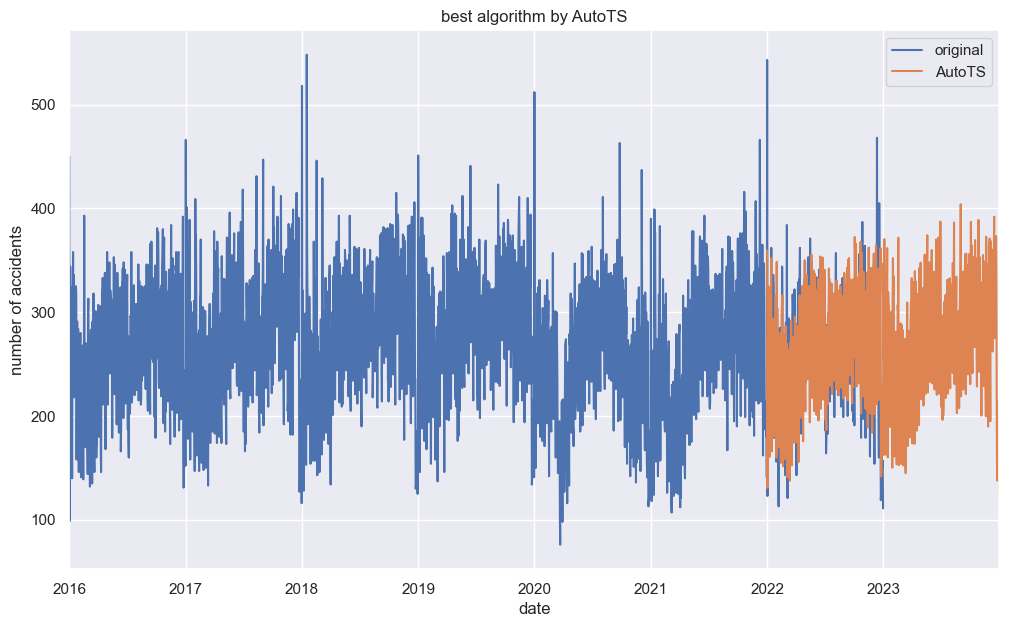

In [138]:
# add results to monthly_predict_df
predict_df['AutoTS'] = [np.nan] * len(dataset_train) + list(forecast['predicted'])

# plot the results
predict_df[['original', 'AutoTS']].plot()
plt.title('best algorithm by AutoTS')
plt.xlabel('date')
plt.ylabel('number of accidents')

In [139]:
autots_model.results()

ID               Model  \
0     a5011ac9e6732f42c9dc1acd56af4863               ARIMA   
1     5e75ed52611fa9266c855f5876eb8720   AverageValueNaive   
2     32c21e08eec3d98d9158c35dfb4410ba   AverageValueNaive   
3     d8bd60351c03557d2b76a1f72be762ff   AverageValueNaive   
4     3c205c901c969cb3f2380ccc43f7a36f  DatepartRegression   
...                                ...                 ...   
1877  c0ac396904a23977ec676bf7b83163f3            Ensemble   
1878  cc256c32bc4a35bbddb53674a54db62a            Ensemble   
1879  cc256c32bc4a35bbddb53674a54db62a            Ensemble   
1880  8e37e092544d1fa4835585bc98dd07ba            Ensemble   
1881  817df0e03e62a3454597f63318a3b383            Ensemble   

                                        ModelParameters  \
0     {"p": 4, "d": 0, "q": 12, "regression_type": n...   
1                    {"method": "Mean", "window": null}   
2                    {"method": "Mean", "window": null}   
3                    {"method": "Mean", "window": null}   
4     {"regression_model": {"model": "DecisionTree",...   
...                                                 ...   
1877  {"model_name": "BestN", "model_count": 5, "mod...   
1878  {"model_name": "Dist", "model_count": 2, "mode...   
1879  {"model_name": "Dist", "model_count": 2, "mode...   
1880  {"model_name": "BestN", "model_count": 3, "mod...   
1881  {"model_name": "BestN", "model_count": 3, "mod...   

                               TransformationParameters  \
0     {"fillna": "cubic", "transformations": {"0": "...   
1     {"fillna": "fake_date", "transformations": {"0...   
2     {"fillna": "mean", "transformations": {"0": "C...   
3     {"fillna": "rolling_mean_24", "transformations...   
4     {"fillna": "mean", "transformations": {"0": "C...   
...                                                 ...   
1877                                                 {}   
1878                                                 {}   
1879                                                 {}   
1880                                                 {}   
1881                                                 {}   

      TransformationRuntime             FitRuntime         PredictRuntime  \
0    0 days 00:00:00.002991        0 days 00:00:00 0 days 00:00:43.119722   
1    0 days 00:00:00.037898 0 days 00:00:00.000998 0 days 00:00:00.001996   
2    0 days 00:00:00.068816 0 days 00:00:00.008975 0 days 00:00:00.002977   
3    0 days 00:00:00.029918 0 days 00:00:00.004003 0 days 00:00:00.001995   
4    0 days 00:00:00.040890        0 days 00:00:00 0 days 00:00:01.338419   
...                     ...                    ...                    ...   
1877        0 days 00:00:00 0 days 00:00:34.426422 0 days 00:00:00.001995   
1878        0 days 00:00:00 0 days 00:00:28.799007        0 days 00:00:00   
1879        0 days 00:00:00 0 days 00:00:30.688258        0 days 00:00:00   
1880        0 days 00:00:00 0 days 00:00:04.074411 0 days 00:00:00.006981   
1881        0 days 00:00:00 0 days 00:00:04.039201 0 days 00:00:00.005983   

               TotalRuntime  Ensemble Exceptions  ...  contour_weighted  \
0    0 days 00:00:43.143657         0        NaN  ...          0.693151   
1    0 days 00:00:00.057847         0        NaN  ...          0.695890   
2    0 days 00:00:00.102726         0        NaN  ...          0.528767   
3    0 days 00:00:00.054851         0        NaN  ...          0.745205   
4    0 days 00:00:01.404246         0        NaN  ...          0.542466   
...                     ...       ...        ...  ...               ...   
1877 0 days 00:00:38.474599         1        NaN  ...          0.756164   
1878 0 days 00:00:30.249128         1        NaN  ...          0.731507   
1879 0 days 00:00:32.184259         1        NaN  ...          0.731507   
1880 0 days 00:00:06.059106         1        NaN  ...          0.753425   
1881 0 days 00:00:05.964054         1        NaN  ...          0.750685   

      maxe_weighted  oda_weighted dwae_weighted

In [209]:
from sklearn.metrics import mean_squared_error

target_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)['original'].values
rmse_results = {}

for col in predict_df.columns:
    if col != 'original':
        # Get the predicted values for the current model
        predicted_values = predict_df.tail(periods_to_predict + periods_to_predict).head(periods_to_predict)[col].values

        # Calculate the mean squared error
        mse = mean_squared_error(target_values, predicted_values)

        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(mse)

        # Store the RMSE value in the dictionary
        rmse_results[col] = rmse
        
# Convert the dictionary to a DataFrame for easier visualization
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.sort_values(by='RMSE')

RMSE
AutoTS                      38.361681
prophet                     50.794954
GNN                         54.226930
random forest + grid        55.844640
random forest + randomized  57.009262
random forest + GA          57.038412
MLP + GA                    58.114750
MLP + grid                  61.864364
lstm                        62.548083
rnn                         63.393404
MLP + randomized            64.343236
catboost                    68.180973
svr                         68.353783
arima                       68.675990
xgboost                     69.362818

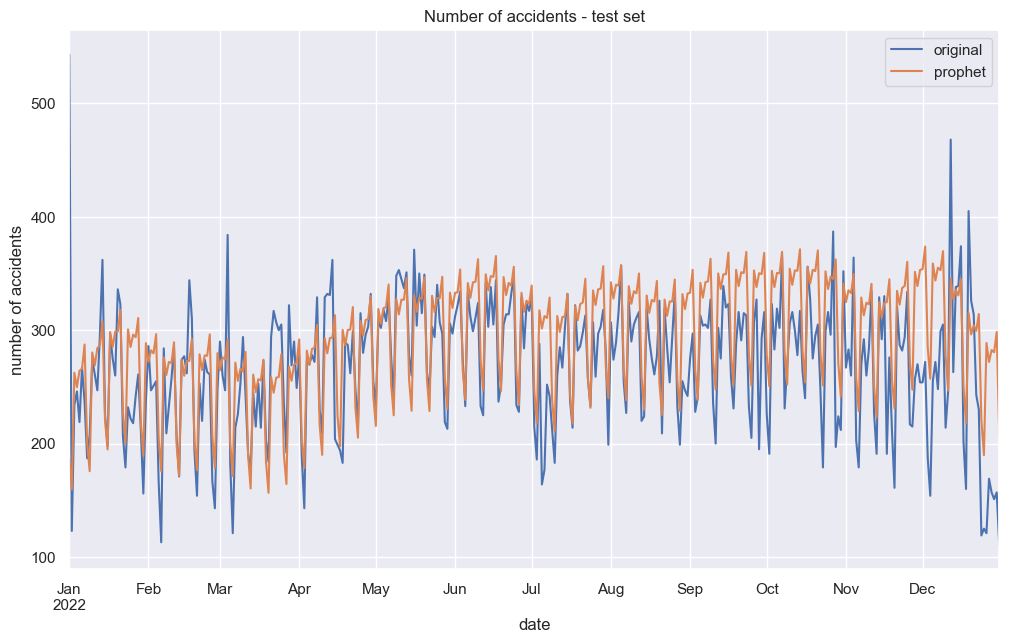

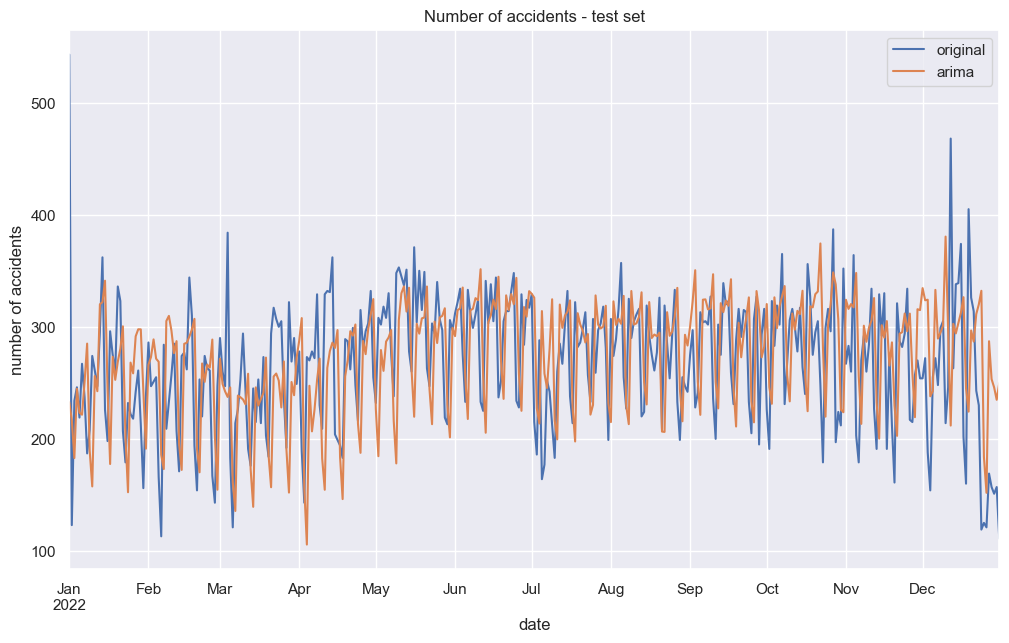

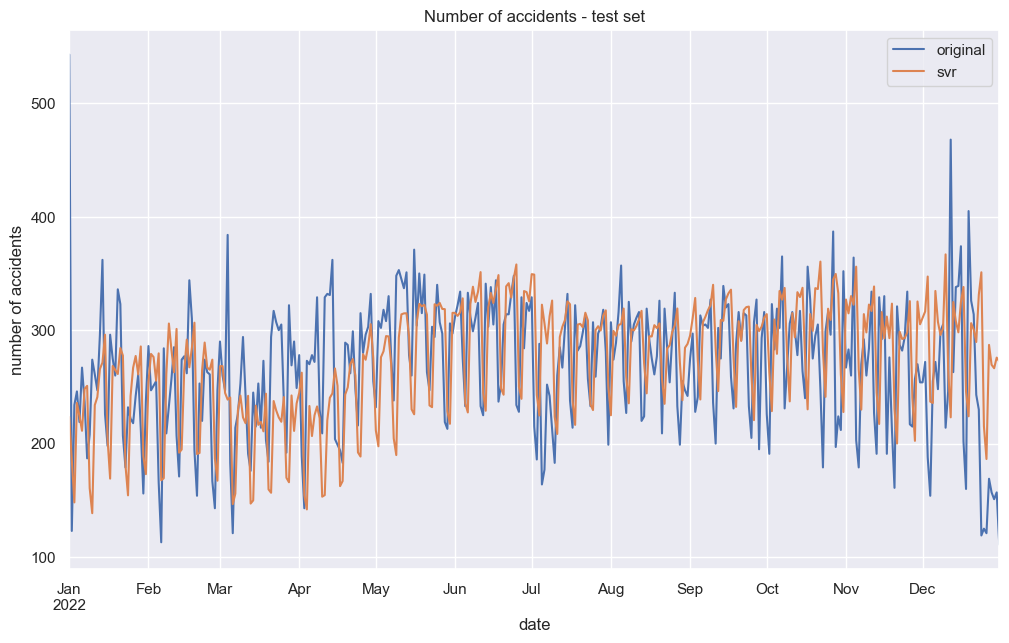

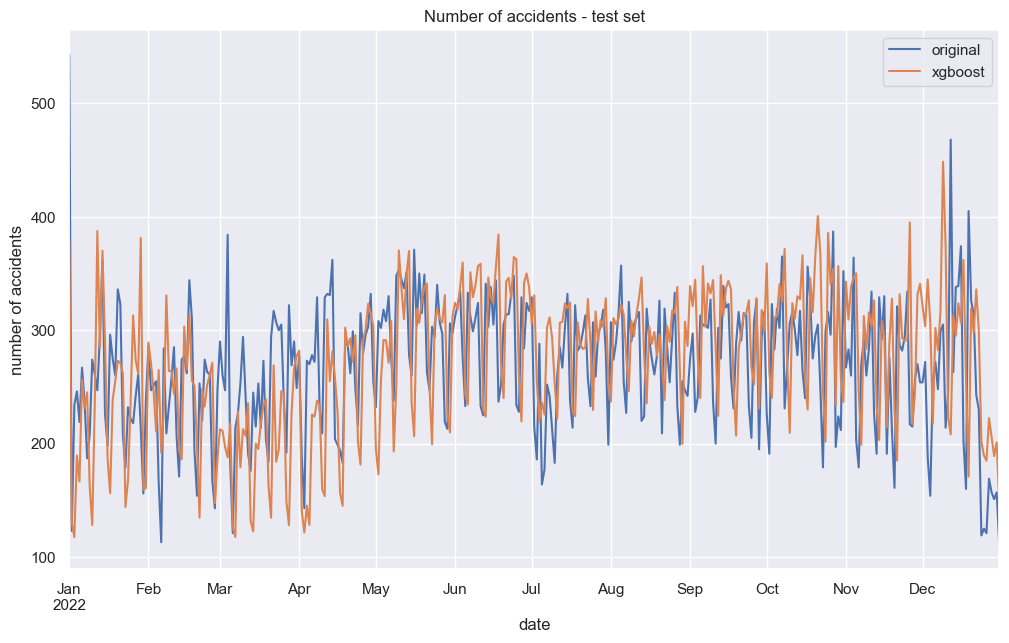

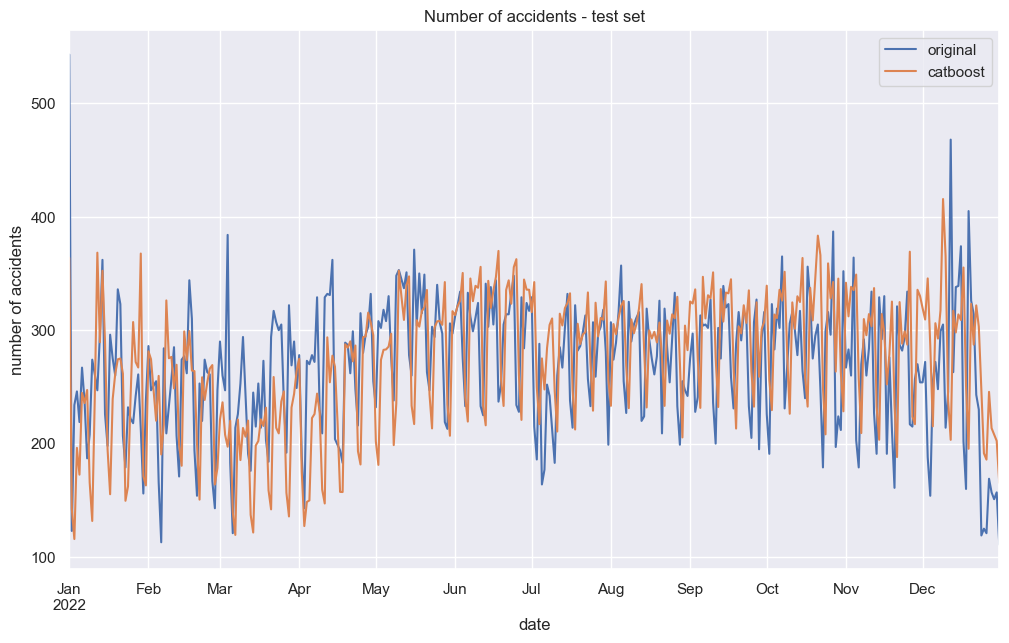

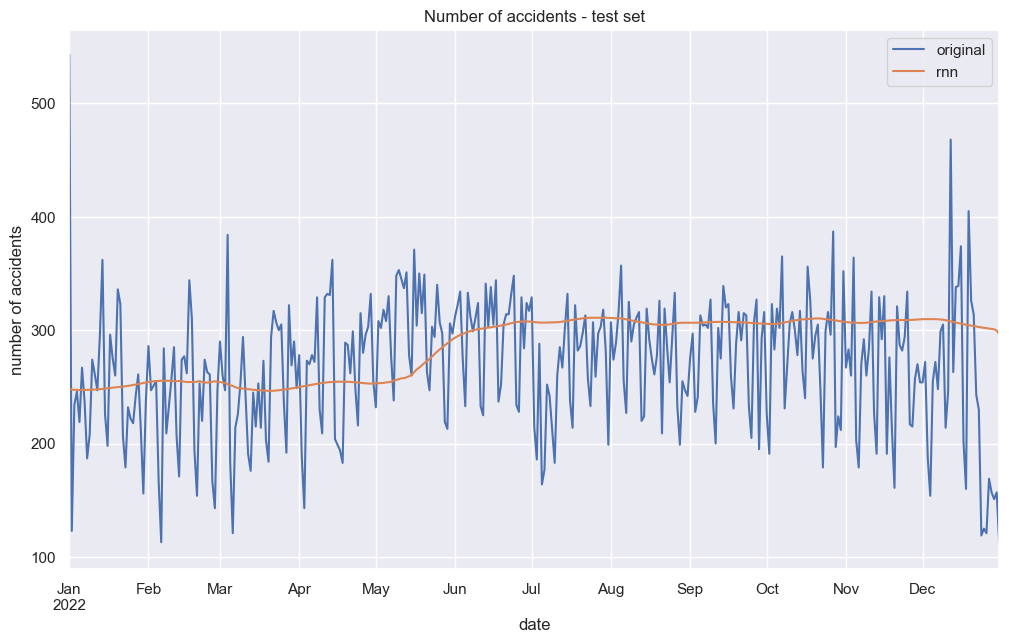

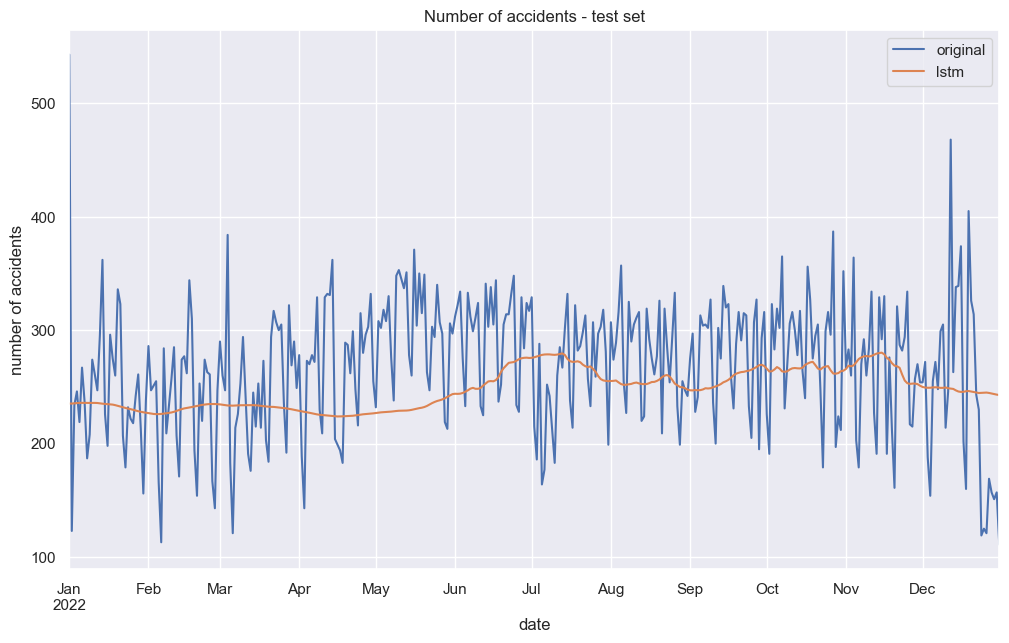

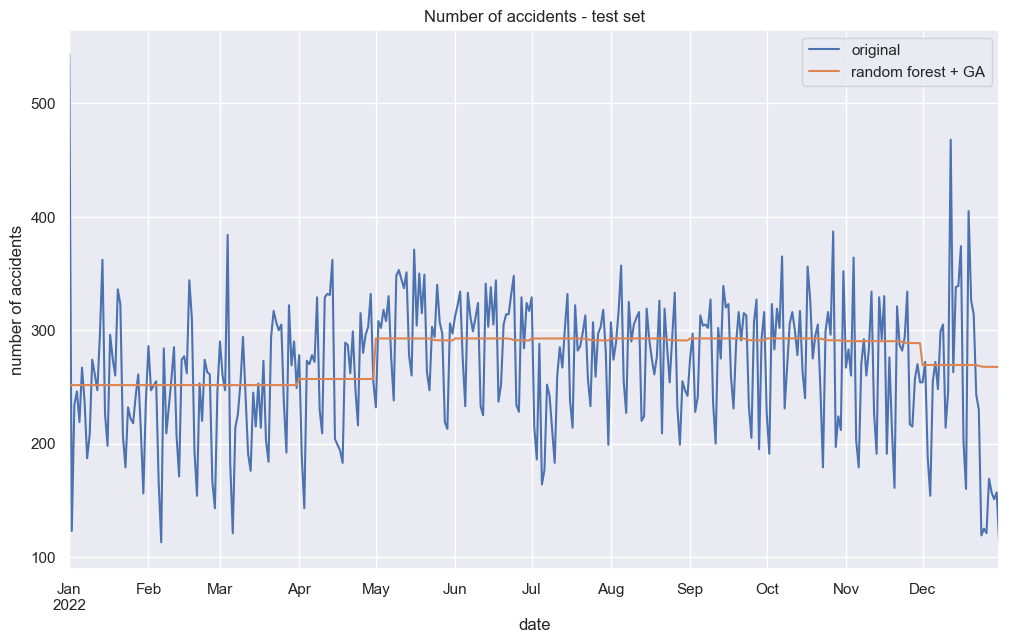

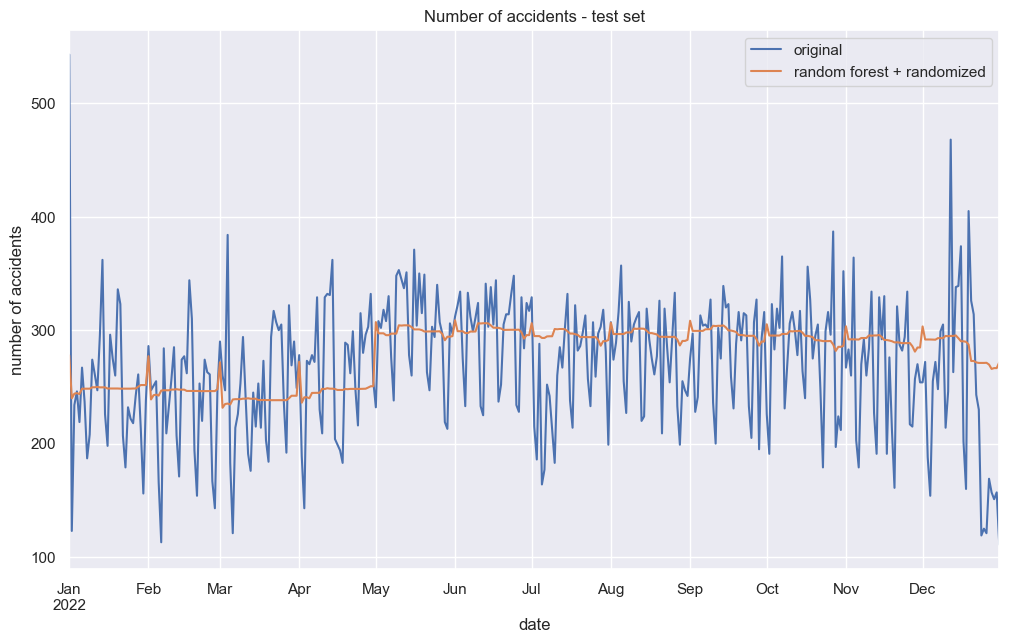

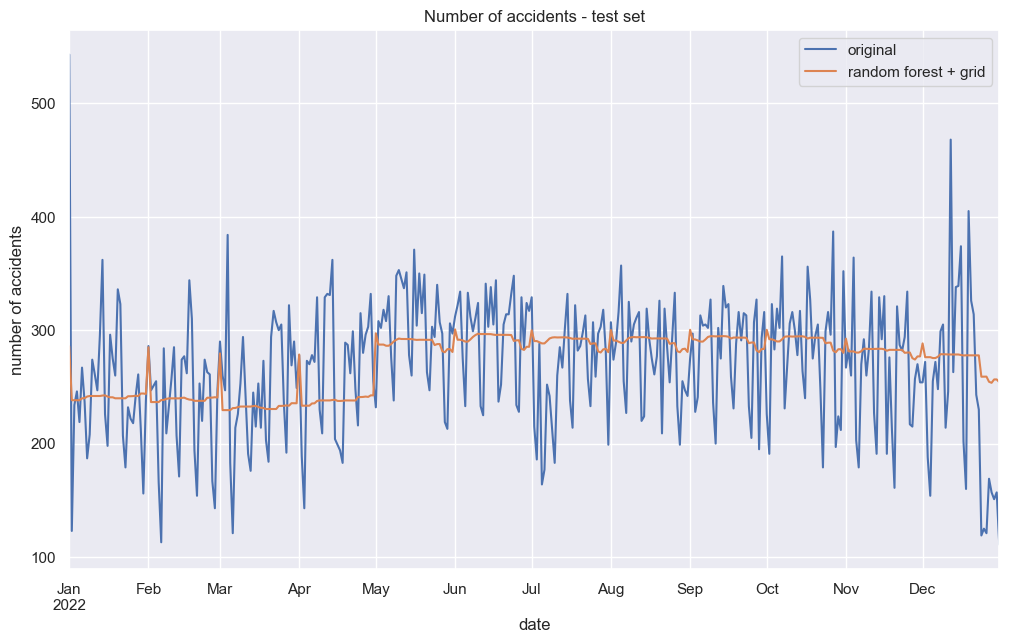

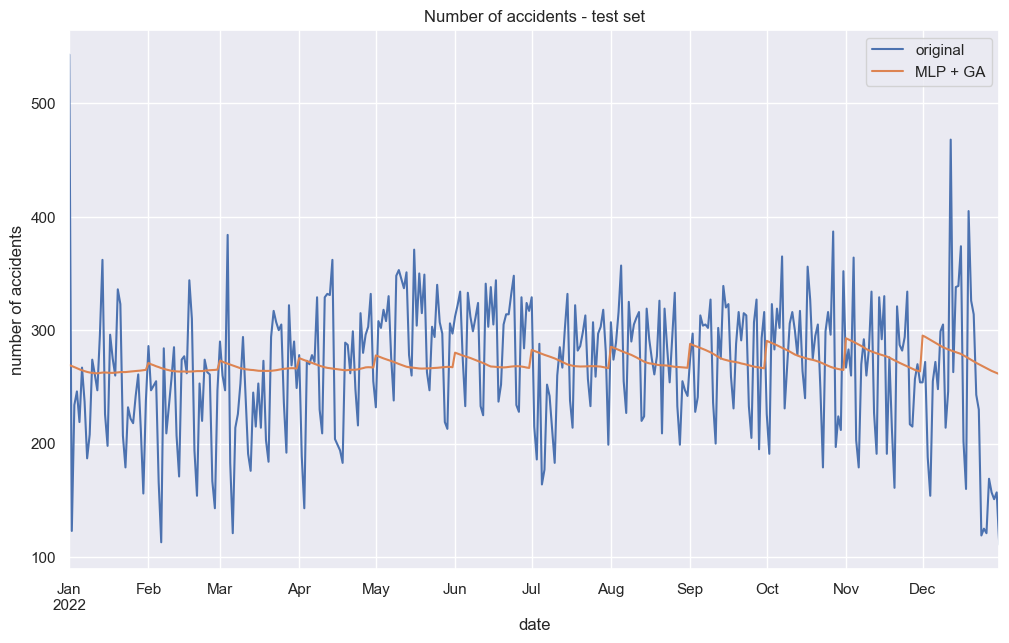

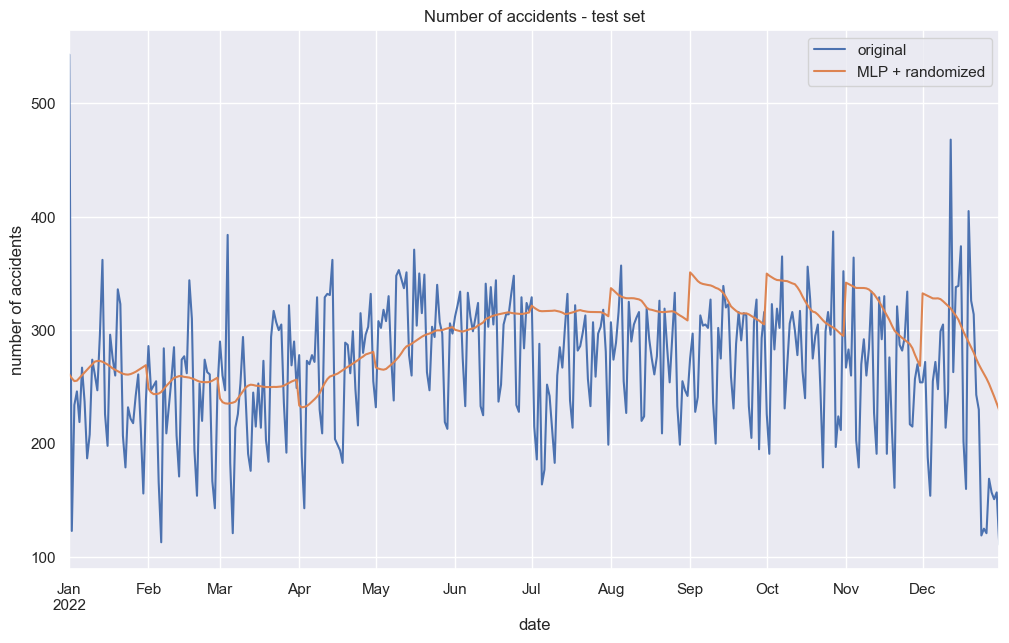

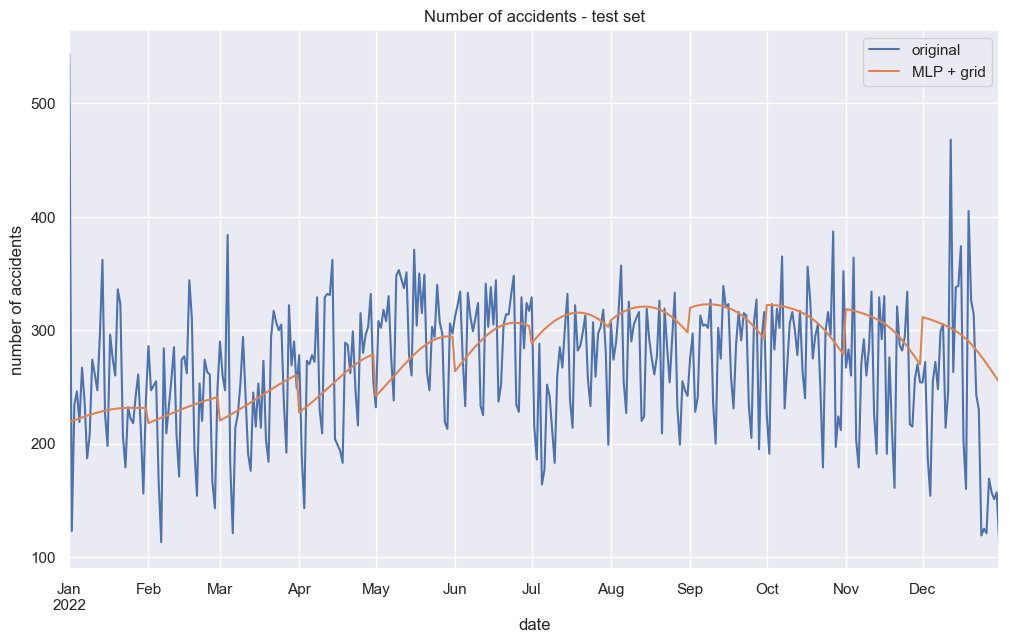

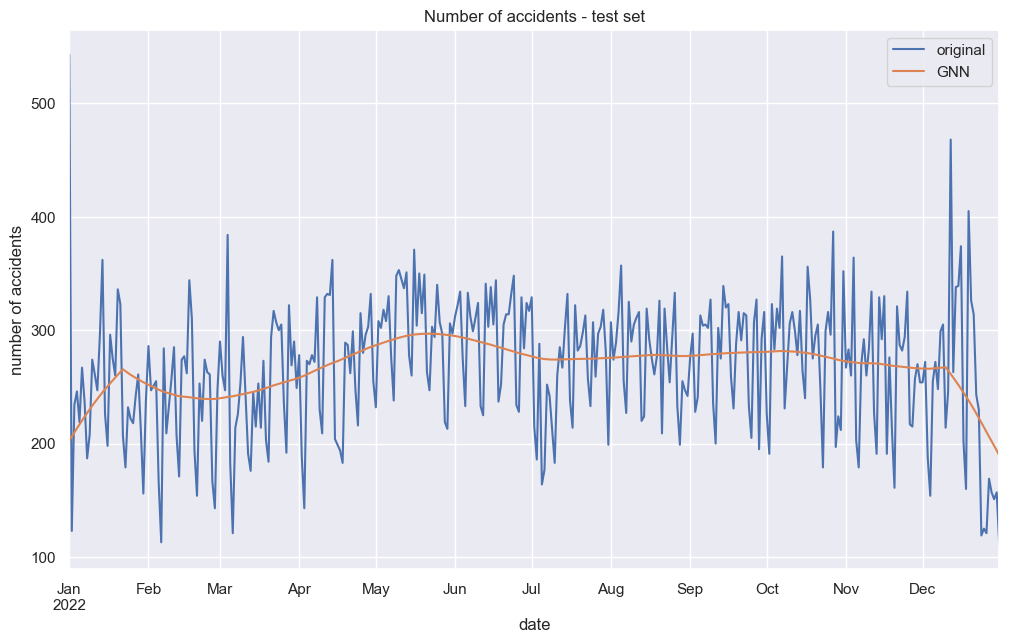

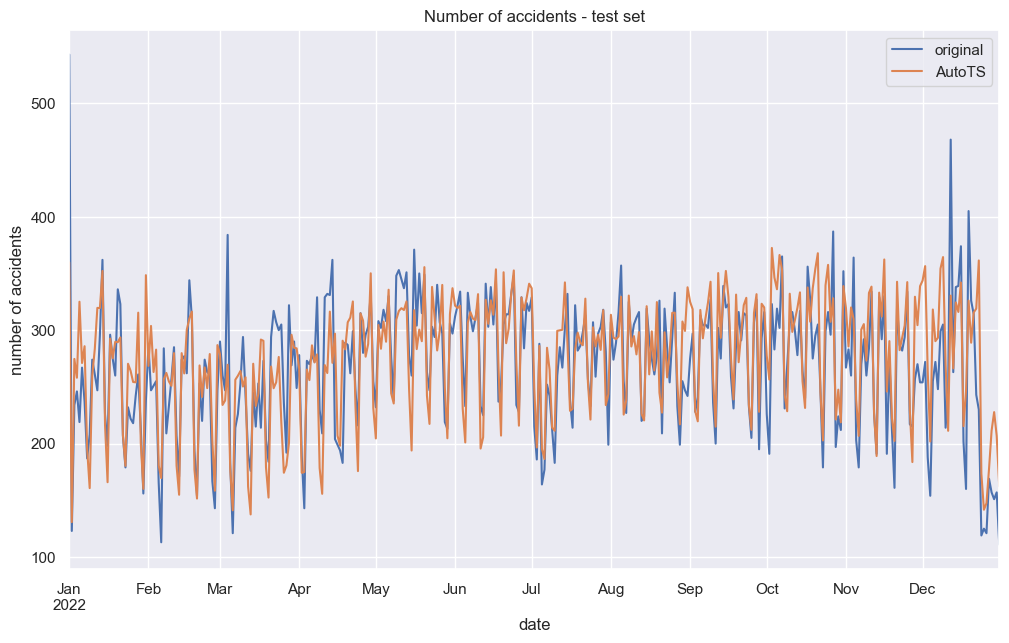

In [210]:
for col in predict_df.columns:
    if col != 'original':
        plt.rcParams['figure.figsize'] = [12, 7]
        predict_df[['original', col]].tail(periods_to_predict + periods_to_predict).head(periods_to_predict).plot()
        plt.title('Number of accidents - test set')
        plt.xlabel('date')
        plt.ylabel('number of accidents')
        plt.show()